In [1]:
import rdkit
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools

from IPython.display import HTML
def show_df(df):
    return HTML(df.to_html(notebook=True))

# Import df

In [2]:
df = pd.read_csv("big_cls_b3e365b9.csv", index_col="index")
df.drop_duplicates(subset="SMILES")
PandasTools.AddMoleculeColumnToFrame(df,'SMILES','Molecule')

len(df)

1350

# Find substrucuture match with reference

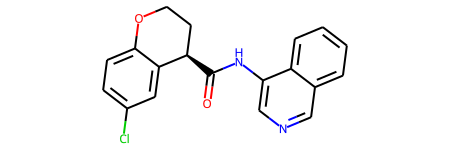

In [3]:
#reference_molecule = [df.loc[df["CID"]=="MAT-POS-b3e365b9-1"]]
reference_molecule = df.loc[13654]["Molecule"]
reference_molecule

In [4]:
mols_list = df["Molecule"]
counter = 0
for mol in mols_list:
    if mol.HasSubstructMatch(reference_molecule, useChirality=True):
        counter += 1
counter

763

# Make generic Murcko Scaffold

In [5]:
from rdkit.Chem.Scaffolds import MurckoScaffold

In [6]:
#Redefine function to include sterochem

def MakeScaffoldGeneric(mol):
    res = Chem.Mol(mol)
    for atom in res.GetAtoms():
        if atom.GetAtomicNum() != 1:
            atom.SetAtomicNum(6)
        atom.SetIsAromatic(False)
        atom.SetFormalCharge(0)
        #atom.SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        atom.SetNoImplicit(0)
        atom.SetNumExplicitHs(0)
    for bond in res.GetBonds():
        bond.SetBondType(Chem.BondType.SINGLE)
        bond.SetIsAromatic(False)
    return Chem.RemoveHs(res)

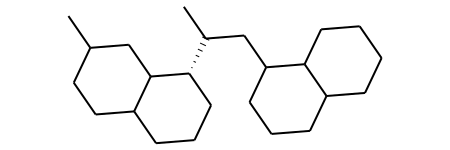

In [7]:
reference_molecule_generic = MakeScaffoldGeneric(reference_molecule)
reference_molecule_generic

In [8]:
mols_list = df["Molecule"]
counter = 0
for mol in mols_list:
    if MakeScaffoldGeneric(mol).HasSubstructMatch(reference_molecule_generic, useChirality=True):
        counter += 1
counter

1350

# Show grid

In [9]:
from rdkit.Chem import AllChem
from rdkit.Chem import Draw,rdDepictor
from rdkit.Chem import rdFMCS

def ShowSeriesGrid(mol_name_pair,reference_molecule=None,highlightAtomLists=None):
    
    mols_to_show = [x for x,y in mol_name_pair]
    names_to_show = [y for x,y in mol_name_pair]
    
    if reference_molecule:
        highlightAtomLists = [MakeScaffoldGeneric(x).GetSubstructMatch(MakeScaffoldGeneric(reference_molecule)) for x in mols_to_show]     

    return Draw.MolsToGridImage(mols_to_show,legends=names_to_show,molsPerRow=5,highlightAtomLists = highlightAtomLists)

# Abstraction

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


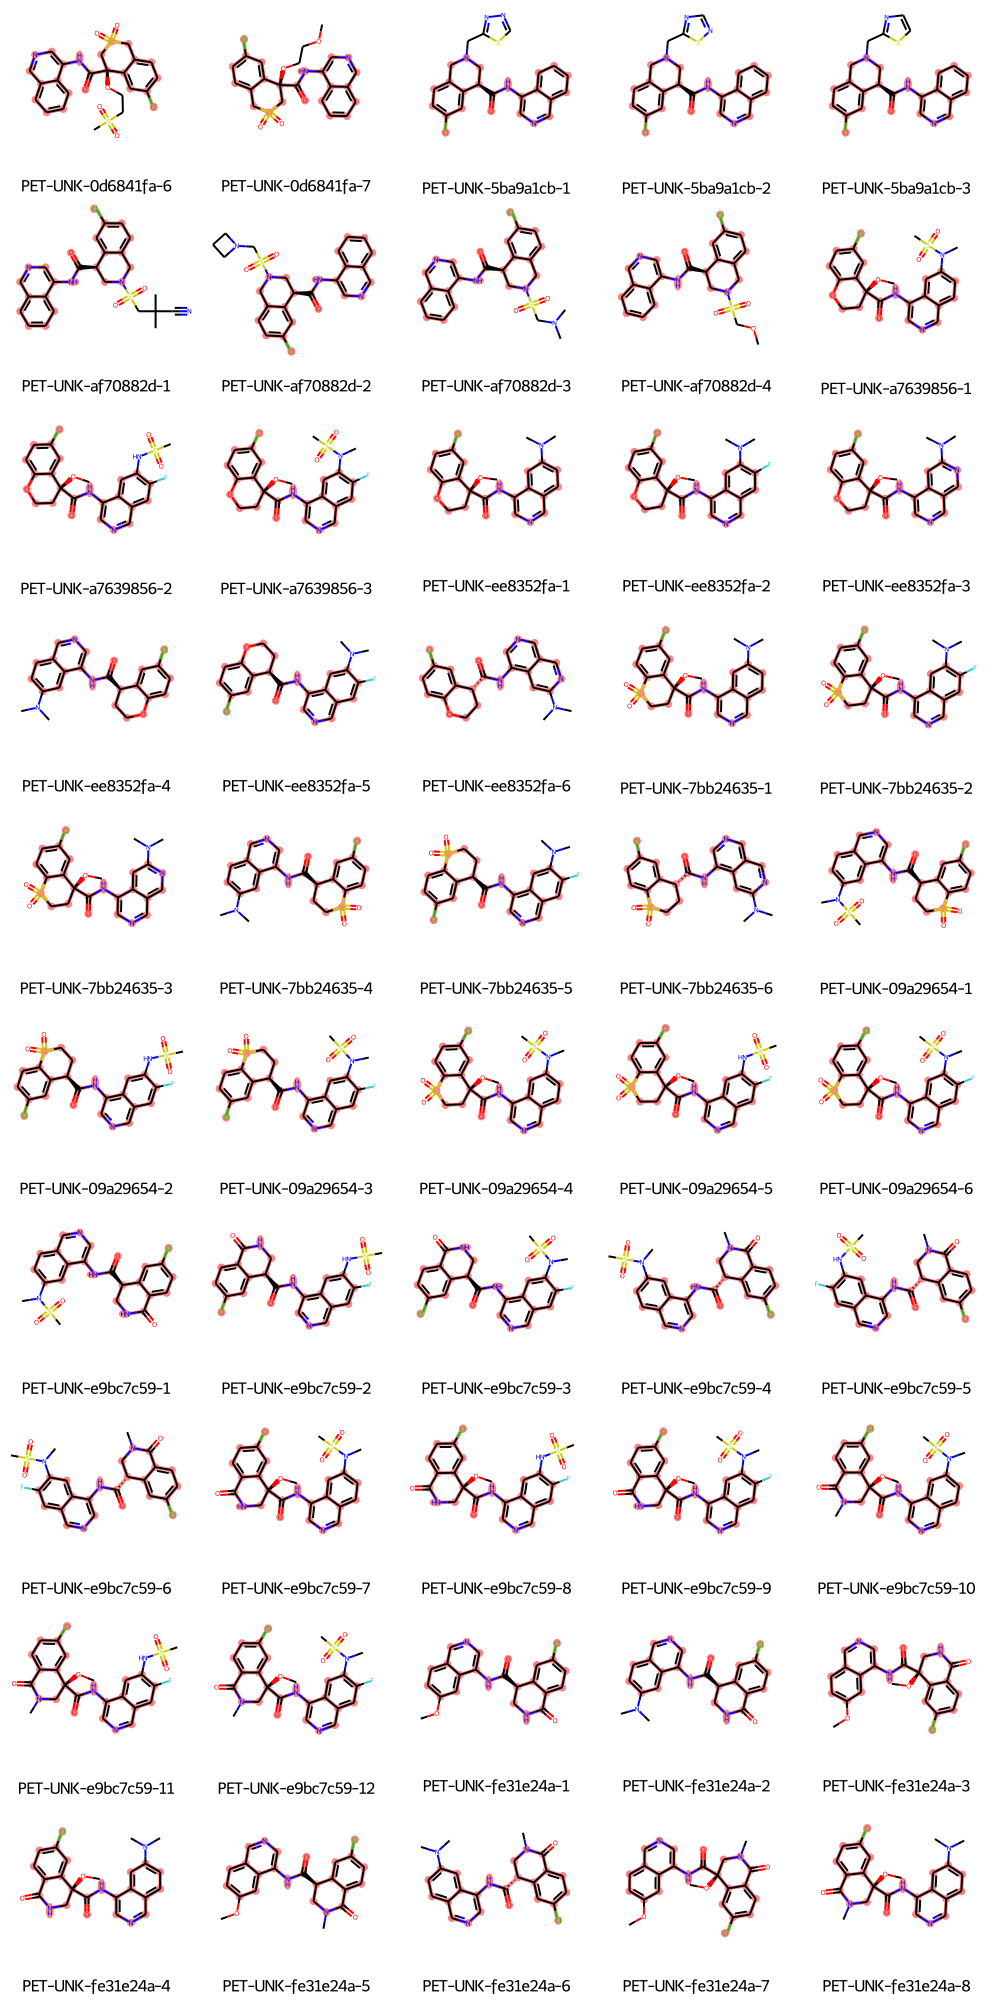

In [10]:
mol_name_pairs = list(df[["Molecule", "CID"]].itertuples(index=False, name=None))[1000:]
ShowSeriesGrid(mol_name_pairs,reference_molecule=reference_molecule)

,CID,SMILES,Molecule
index,,,
13654,MAT-POS-b3e365b9-1,O=C(Nc1cncc2ccccc12)[C@@H]1CCOc2ccc(Cl)cc21,
13663,EDJ-MED-e4b030d8-1,C[C@@]1(C(=O)Nc2cncc3ccccc23)C(=O)COc2ccc(Cl)cc21,
13664,EDJ-MED-e4b030d8-2,C[C@@H]1C[C@@H](C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2O1,
13665,EDJ-MED-e4b030d8-3,C[C@H]1C[C@@H](C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2O1,
13666,EDJ-MED-e4b030d8-4,O=C(Nc1cncc2ccccc12)[C@@H]1CCOc2c(OC3COC3)cc(Cl)cc21,

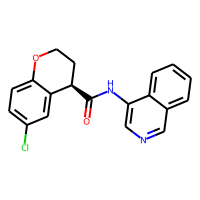
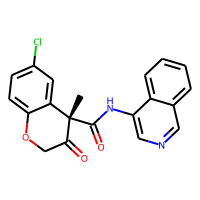
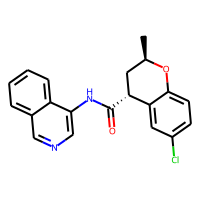
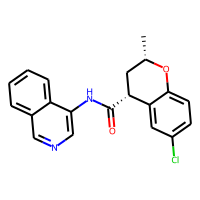
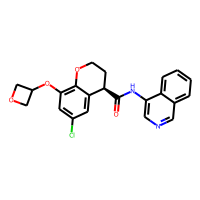

In [11]:
show_df(df.head())

In [12]:
from rdkit.Chem.rdmolops import ReplaceCore

def getSideChainsFromScaffold(mol, core):
    return(ReplaceCore(mol,core, mol.GetSubstructMatch(core)))

In [13]:
#df["side_chains"] = df.apply(lambda x: getSideChains(x["Molecule"]), axis = 1)

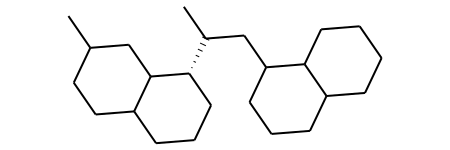

In [14]:
reference_molecule_generic

In [15]:
from rdkit.Chem import ReplaceCore
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdmolops

In [16]:
from rdkit.Chem import rdchem
from rdkit.Chem import rdmolops

from rdkit.Chem import rdMolHash

def find_true_murcko(mol):
    
    mol = MurckoScaffold.GetScaffoldForMol(mol)
    
    atom_to_remove = []
    atom_to_clean = []
    
    for a in mol.GetAtoms():
        mol.GetAtomWithIdx(a.GetIdx()).SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        
        #Replace heteroatoms with dummy atoms or wildcard
        
        
        if len(a.GetBonds()) == 1:
            atom_to_remove.append(a.GetIdx())
            
            bond = a.GetBonds()[0]
            begin_atom = bond.GetBeginAtom()
            begin_atom_idx = bond.GetBeginAtomIdx()
            end_atom = bond.GetEndAtom()
            end_atom_idx = bond.GetEndAtomIdx()
            
            #This is bad code
            if begin_atom_idx == a.GetIdx():
                atom_to_clean.append((end_atom_idx, end_atom.GetHybridization()))
            else:
                atom_to_clean.append((begin_atom_idx, begin_atom.GetHybridization()))

    #print(atom_to_clean)
    
    if len(atom_to_remove) > 0:
        emol = rdchem.RWMol(mol)
        for a in atom_to_remove[::-1]:
            emol.RemoveAtom(a)
            
    
    #emol = rdkit.Chem.rdmolops.RemoveHs(emol)
    #display(emol)
    try:
        Chem.SanitizeMol(emol)

    except:
        return False
    #emol.GetMolecule()
    #neutralize_atoms()
    
    emol = MurckoScaffold.GetScaffoldForMol(emol)
    
    #This is to account for issues of atom identity
    
    """
    smiles = Chem.MolToSmiles(emol)
    for letter in ["C","c","N","n","O","o","s","S"]:
        smiles = smiles.replace(letter,"*")
    emol = Chem.MolFromSmiles(smiles)
    """
    
    
    
    return emol

This often fails due to heteroatoms in substructure. 

In [17]:
def GetSidechains(mol1,mol2):
    core1 = find_true_murcko(mol1)
    core2 = find_true_murcko(mol2)
    #ref_mol = Chem.MolFromSmiles('*1***2*(*1)****2***1****2*****21')
    
    if not core1 or not core2:
        return False
        #return (mol1,core1,mol2, core2,"Murcko fail")

    if Chem.MolToSmiles(core1) == Chem.MolToSmiles(core2):
        #print("True match")
        frags1 = ReplaceCore(mol1,core1, mol1.GetSubstructMatch(core1), labelByIndex=True)
        frags2 = ReplaceCore(mol2,core1, mol2.GetSubstructMatch(core1), labelByIndex=True)
    
    elif core2.GetSubstructMatch(core1):
        #print("core1 found in core2")
        frags1 = ReplaceCore(mol1,core1, mol1.GetSubstructMatch(core1), labelByIndex=True)
        frags2 = ReplaceCore(mol2,core1, mol2.GetSubstructMatch(core1), labelByIndex=True)
        
    elif core1.GetSubstructMatch(core2):
        #print("core2 found in core1")
        frags1 = ReplaceCore(mol1,core2, mol1.GetSubstructMatch(core2), labelByIndex=True)
        frags2 = ReplaceCore(mol2,core2, mol2.GetSubstructMatch(core2), labelByIndex=True)
    
    #elif core1.GetSubstructMatch(ref_mol) and core2.GetSubstructMatch(ref_mol):
        #In the worst case scenario, all molecules should contain the same substructure as the reference
        #Used to seed the cluster 
        #frags1 = ReplaceCore(mol1,ref_mol, mol1.GetSubstructMatch(ref_mol), labelByIndex=True)
        #frags2 = ReplaceCore(mol2,ref_mol, mol2.GetSubstructMatch(ref_mol), labelByIndex=True)

    else:    
        return False
        #return (mol1,core1,mol2, core2,"Substructure match fail")
        #return False
        #raise("Error in core matching. No cores have substructure match")
        
        
        
    #array = [mol1, core1, frags1,mol2,core2,frags2]
    #return(Draw.MolsToGridImage(array,molsPerRow=3))

    return (frags1,frags2)

In [18]:
def GetUniqueSideChains(frags1,frags2):
    set1 = set(Chem.MolToSmiles(frags1).split("."))
    set2 = set(Chem.MolToSmiles(frags2).split("."))
    not_shared_side_chains = (set1 - set2).union(set2 - set1)
    
    return list(not_shared_side_chains)

In [48]:
"""
Define different function for grow and pertubation
Pertubation requires the atom index to be the same
"""


def GraftFragmentToBenzene(fragment):
    """
    Input: Fragment is string
    Output: Benzene scaffold
    """

    
    try:
        fragment = re.split('\[(?:[0-99])\*\]', fragment)
        #fragment = fragment.split("]")[1]
        if len(fragment) > 1:
            #This mol is ring transformation
            return Chem.MolFromSmiles("C1=CC=CC=C1")
    except:
        print()
        #raise("Error")
    
    #double bond oxygen or 2x C1
    """
    if fragment.count("1") > 1:
        new_fragment = "C"
        fragment = fragment.split()
        for letter in fragment:
            if letter == "1":
                letter = "2"
            new_fragment += letter
        fragment = new_fragment
    """
    
    #benzene = Chem.MolFromSmiles("C1=CC=CC=C1")
    benzene = Chem.MolFromSmiles("CC1=CC=CC=C1")
    fragment = '[1*]'+fragment
    fragment = Chem.MolFromSmiles(fragment)
    
    mod_mol = Chem.ReplaceSubstructs(fragment, 
                                 Chem.MolFromSmiles('[1*]'), 
                                 benzene,
                                 replaceAll=True
                                    )
    return mod_mol[0]

In [49]:
entire_mol_list = list(df["Molecule"])
shortened_mol_list = entire_mol_list[:100]

entire_mol_index = list(df.index)
shortened_mol_index = entire_mol_index[:100]

In [50]:
from tqdm import tqdm
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [51]:
results_array = []
counter = 0
#graft_pair_df = pd.DataFrame(columns=["idx1","idx2","fragments","graft1","graft2"])
graft_pair_df = pd.DataFrame(columns=["fragments","graft1","graft2"])

for i in tqdm(range(len(shortened_mol_list))):
    for j in range(i):
        
        if GetSidechains(entire_mol_list[i],entire_mol_list[j]):
            frags1,frags2 = GetSidechains(entire_mol_list[i],entire_mol_list[j])
        else:
            continue
        unique_sidechains = GetUniqueSideChains(frags1,frags2)
        print(unique_sidechains)
        
        if len(unique_sidechains) == 1:
            #grow
            b1 = Chem.MolFromSmiles("C1=CC=CC=C1")
            b2 = GraftFragmentToBenzene(unique_sidechains[0])
            
        elif len(unique_sidechains) == 2:
            b1 = GraftFragmentToBenzene(unique_sidechains[0])
            b2 = GraftFragmentToBenzene(unique_sidechains[1])
                
        else:
            #Multiple pertubations
            counter += 1
            
        
        #row = {"idx1":df.index[i],"idx2":df.index[j],"fragments":fragments,"graft1":graft1,"graft2":graft2}
        row = {"fragments":unique_sidechains,"graft1":b1,"graft2":b2}
        graft_pair_df = graft_pair_df.append(row,ignore_index=True)
        

  8%|████                                               | 8/100 [00:00<00:01, 66.32it/s]

['*C', '[13*]=O']


['*C']

['[2*]C', '*C', '[1*]=O']
['*C']

['[2*]C', '*C', '[1*]=O']
[]
['[17*]OC1COC1']

['[17*]OC1COC1', '*C', '[13*]=O']
['[19*]OC1COC1', '*C']


['[19*]OC1COC1', '*C']


['[17*]C1COC1']

['[17*]C1COC1', '*C', '[13*]=O']
['[19*]C1COC1', '*C']


['[19*]C1COC1', '*C']


['*CCC']

['*=O', '*CCC', '[9*]C']
['*CCC', '[1*]C']


['*CCC', '[1*]C']


['*CCC', '[4*]OC1COC1']


['*CCC', '[4*]C1COC1']


['*OC']

['[9*]C', '*OC', '[8*]=O']
['*OC', '[7*]C']


['*OC', '[7*]C']


['*OC1COC1', '*OC']


['*C1COC1', '*OC']


['*OC', '[8*]CCC']


['*C']

['[19*]=O', '[6*]C', '*C']
['[20*]C', '*C']


['[20*]C', '*C']


['*C', '[3*]OC1COC1']


['[3*]C1COC1', '*C']


['[19*]CCC', '*C']


['[3*]OC', '*C']


['[20*]Cl']

['[20*]Cl', '[12*]C', '[13*]=O']
['[20*]Cl', '[14*]C']


['[20*]Cl', '[14*]C']


['[20*]Cl', '[17*]OC1COC1']


['[20*]Cl', '[17*]C1COC1']


['[20*]Cl', '[13*]CCC']


['[20*]Cl', '[17*]OC']


['[20*]Cl', '[20*]C']


['*C']

['*=O', '*C', '[9*]C']
['*C', '[1*]C']


['*C', '

 15%|███████▌                                          | 15/100 [00:00<00:02, 32.06it/s]

['*C(C)=O', '[2*]C']


['[3*]C', '*C(C)=O']


['[1*]C(=O)C[12*]']

['[13*]=O', '*CC([2*])=O', '*C']
['*C', '[2*]CC([4*])=O']


['*C', '[2*]CC([4*])=O']


['*CCC', '[9*]CC([11*])=O']


['*OC', '[9*]CC([11*])=O']


['[6*]CC([8*])=O', '*C']


['[1*]C(=O)C[12*]', '[20*]Cl']


['[9*]CC([11*])=O', '*C']


['*CC([2*])=O', '*C']


['[9*]CC([11*])=O', '*C']


['*C(C)=O', '*C(=O)C[2*]']


['[1*]C(=O)CC[12*]']

['[13*]=O', '*C', '*CCC([2*])=O']
['[2*]CCC([4*])=O', '*C']


['[2*]CCC([4*])=O', '*C']


['*CCC', '[9*]CCC([11*])=O']


['*OC', '[9*]CCC([11*])=O']


['*C', '[6*]CCC([8*])=O']


['[20*]Cl', '[1*]C(=O)CC[12*]']


['[9*]CCC([11*])=O', '*C']


['*C', '*CCC([2*])=O']


['[9*]CCC([11*])=O', '*C']


['*C(=O)CC[2*]', '*C(C)=O']


['[1*]C(=O)CN1CCN(C(C)=O)CC1']

['[2*]C(=O)CN1CCN(C(C)=O)CC1', '*C', '[13*]=O']
['*C', '[4*]C(=O)CN1CCN(C(C)=O)CC1']


['*C', '[4*]C(=O)CN1CCN(C(C)=O)CC1']


['*CCC', '[11*]C(=O)CN1CCN(C(C)=O)CC1']


['*OC', '[11*]C(=O)CN1CCN(C(C)=O)CC1']


['[8*]C(=O)CN1CCN(C(C)=O)CC1'

 20%|██████████                                        | 20/100 [00:00<00:03, 21.74it/s]

['[3*]=O', '*C(=O)CCl', '[2*]C']
['*C(=O)CCl', '[4*]C']


['*C(=O)CCl', '[4*]C']


['*C(=O)CCl', '[7*]OC1COC1']


['[7*]C1COC1', '*C(=O)CCl']


['[3*]CCC', '*C(=O)CCl']


['*C(=O)CCl', '[7*]OC']


['*C(=O)CCl', '[10*]C']


['[10*]Cl', '*C(=O)CCl']


['[3*]C', '*C(=O)CCl']


['*C(=O)CCl', '[2*]C']


['[3*]C', '*C(=O)CCl']


['*C(=O)CCl', '*C(C)=O']


['*C(=O)CCl', '*C(=O)C[2*]']


['*C(=O)CCl', '*C(=O)CC[2*]']


['*C(=O)CN1CCN(C(C)=O)CC1', '*C(=O)CCl']


['*C(=O)C=C']

['*C(=O)C=C', '[3*]=O', '[2*]C']
['*C(=O)C=C', '[4*]C']


['*C(=O)C=C', '[4*]C']


['*C(=O)C=C', '[7*]OC1COC1']


['[7*]C1COC1', '*C(=O)C=C']


['*C(=O)C=C', '[3*]CCC']


['*C(=O)C=C', '[7*]OC']


['*C(=O)C=C', '[10*]C']


['*C(=O)C=C', '[10*]Cl']


['*C(=O)C=C', '[3*]C']


['*C(=O)C=C', '[2*]C']


['*C(=O)C=C', '[3*]C']


['*C(=O)C=C', '*C(C)=O']


['*C(=O)C=C', '*C(=O)C[2*]']


['*C(=O)C=C', '*C(=O)CC[2*]']


['*C(=O)C=C', '*C(=O)CN1CCN(C(C)=O)CC1']


['*C(=O)C=C', '*C(=O)CCl']


['[17*]OC1CC(=O)N1']

['[13*]=O', '*C', 

 23%|███████████▌                                      | 23/100 [00:01<00:04, 18.40it/s]

['[4*]OC1CC(=O)N1', '*C']


['*C', '[17*]OC1CC(=O)N1']


['[4*]OC1CC(=O)N1', '*C']


['*C(C)=O', '[7*]OC1CC(=O)N1']


['*C(=O)CCl', '[7*]OC1CC(=O)N1']


['*C(=O)C=C', '[7*]OC1CC(=O)N1']


['[12*]CCC1CCCCC1', '[17*]OC1CC(=O)N1']


['*C', '[13*]=O', '*CCC1CCCCC1', '[17*]OC1CC(=O)N1']
['[19*]OC1CC(=O)N1', '[2*]CCC1CCCCC1', '*C']
['[19*]OC1CC(=O)N1', '[2*]CCC1CCCCC1', '*C']
['*CCC', '[9*]CCC1CCCCC1', '[4*]OC1CC(=O)N1']
['*OC1CC(=O)N1', '[9*]CCC1CCCCC1', '*OC']
['[6*]CCC1CCCCC1', '[3*]OC1CC(=O)N1', '*C']
['[20*]Cl', '[12*]CCC1CCCCC1', '[17*]OC1CC(=O)N1']
['[9*]CCC1CCCCC1', '[4*]OC1CC(=O)N1', '*C']
['*C', '*CCC1CCCCC1', '[17*]OC1CC(=O)N1']
['[9*]CCC1CCCCC1', '[4*]OC1CC(=O)N1', '*C']
['[2*]CCC1CCCCC1', '*C(C)=O', '[7*]OC1CC(=O)N1']
['*C(=O)CCl', '[2*]CCC1CCCCC1', '[7*]OC1CC(=O)N1']
['*C(=O)C=C', '[2*]CCC1CCCCC1', '[7*]OC1CC(=O)N1']
['[13*]CCC1CCCCC1']

['[12*]CCC1CCCCC1']

['[13*]=O', '*CCC1CCCCC1', '*C']
['[2*]CCC1CCCCC1', '*C']


['[2*]CCC1CCCCC1', '*C']


['*CCC', '[9*]CCC1CCCCC1']


['[9*

 26%|█████████████                                     | 26/100 [00:01<00:04, 17.50it/s]

['[17*]OC1CCC2(CCC2)N1']

['[17*]OC1CCC2(CCC2)N1', '*C', '[13*]=O']
['[19*]OC1CCC2(CCC2)N1', '*C']


['[19*]OC1CCC2(CCC2)N1', '*C']


['[4*]OC1CCC2(CCC2)N1', '*CCC']


['*OC1CCC2(CCC2)N1', '*OC']


['[3*]OC1CCC2(CCC2)N1', '*C']


['[20*]Cl', '[17*]OC1CCC2(CCC2)N1']


['[4*]OC1CCC2(CCC2)N1', '*C']


['[17*]OC1CCC2(CCC2)N1', '*C']


['[4*]OC1CCC2(CCC2)N1', '*C']


['[7*]OC1CCC2(CCC2)N1', '*C(C)=O']


['*C(=O)CCl', '[7*]OC1CCC2(CCC2)N1']


['*C(=O)C=C', '[7*]OC1CCC2(CCC2)N1']


['[17*]OC1CC2(CCC2)N1']

['[13*]=O', '*C', '[17*]OC1CC2(CCC2)N1']
['[19*]OC1CC2(CCC2)N1', '*C']


['[19*]OC1CC2(CCC2)N1', '*C']


['[4*]OC1CC2(CCC2)N1', '*CCC']


['*OC1CC2(CCC2)N1', '*OC']


['[3*]OC1CC2(CCC2)N1', '*C']


['[20*]Cl', '[17*]OC1CC2(CCC2)N1']


['[4*]OC1CC2(CCC2)N1', '*C']


['*C', '[17*]OC1CC2(CCC2)N1']


['[4*]OC1CC2(CCC2)N1', '*C']


['[7*]OC1CC2(CCC2)N1', '*C(C)=O']


['*C(=O)CCl', '[7*]OC1CC2(CCC2)N1']


['*C(=O)C=C', '[7*]OC1CC2(CCC2)N1']


['*=O', '*CCC*']


['[17*]OC1CC2(COC2)N1']

['[17*]OC1

 28%|██████████████                                    | 28/100 [00:01<00:04, 15.86it/s]

['[4*]OC1CC2(COC2)N1', '*C']


['[17*]OC1CC2(COC2)N1', '*C']


['[4*]OC1CC2(COC2)N1', '*C']


['[7*]OC1CC2(COC2)N1', '*C(C)=O']


['[7*]OC1CC2(COC2)N1', '*C(=O)CCl']


['[7*]OC1CC2(COC2)N1', '*C(=O)C=C']


['*=O', '*COC*']


['[17*]OC1CC2(CC2)CN1']

['[17*]OC1CC2(CC2)CN1', '*C', '[13*]=O']
['[19*]OC1CC2(CC2)CN1', '*C']


['[19*]OC1CC2(CC2)CN1', '*C']


['*CCC', '[4*]OC1CC2(CC2)CN1']


['*OC1CC2(CC2)CN1', '*OC']


['[3*]OC1CC2(CC2)CN1', '*C']


['[20*]Cl', '[17*]OC1CC2(CC2)CN1']


['[4*]OC1CC2(CC2)CN1', '*C']


['[17*]OC1CC2(CC2)CN1', '*C']


['[4*]OC1CC2(CC2)CN1', '*C']


['[7*]OC1CC2(CC2)CN1', '*C(C)=O']


['*C(=O)CCl', '[7*]OC1CC2(CC2)CN1']


['*C(=O)C=C', '[7*]OC1CC2(CC2)CN1']


['[17*]OC1CC2(CC2)N1']

['[17*]OC1CC2(CC2)N1', '*C', '[13*]=O']
['[19*]OC1CC2(CC2)N1', '*C']


['[19*]OC1CC2(CC2)N1', '*C']


['*CCC', '[4*]OC1CC2(CC2)N1']


['*OC', '*OC1CC2(CC2)N1']


['[3*]OC1CC2(CC2)N1', '*C']


['[20*]Cl', '[17*]OC1CC2(CC2)N1']


['[4*]OC1CC2(CC2)N1', '*C']


['[17*]OC1CC2(CC2)N1', '*C'

 30%|███████████████                                   | 30/100 [00:01<00:04, 14.20it/s]

['*C(=O)CCl', '[7*]OC1CC2(CC2)N1']


['*C(=O)C=C', '[7*]OC1CC2(CC2)N1']


['*CC*', '*=O']


['[17*]CC1CCC2(CCC2)N1']

['[13*]=O', '*C', '[17*]CC1CCC2(CCC2)N1']
['[19*]CC1CCC2(CCC2)N1', '*C']


['[19*]CC1CCC2(CCC2)N1', '*C']


['[4*]CC1CCC2(CCC2)N1', '*CCC']


['*CC1CCC2(CCC2)N1', '*OC']


['[3*]CC1CCC2(CCC2)N1', '*C']


['[20*]Cl', '[17*]CC1CCC2(CCC2)N1']


['[4*]CC1CCC2(CCC2)N1', '*C']


['*C', '[17*]CC1CCC2(CCC2)N1']


['[4*]CC1CCC2(CCC2)N1', '*C']


['[7*]CC1CCC2(CCC2)N1', '*C(C)=O']


['[7*]CC1CCC2(CCC2)N1', '*C(=O)CCl']


['*C(=O)C=C', '[7*]CC1CCC2(CCC2)N1']


['[17*]CC1CC2(CCC2)N1']

['[17*]CC1CC2(CCC2)N1', '*C', '[13*]=O']
['[19*]CC1CC2(CCC2)N1', '*C']


['[19*]CC1CC2(CCC2)N1', '*C']


['*CCC', '[4*]CC1CC2(CCC2)N1']


['*OC', '*CC1CC2(CCC2)N1']


['[3*]CC1CC2(CCC2)N1', '*C']


['[20*]Cl', '[17*]CC1CC2(CCC2)N1']


['[4*]CC1CC2(CCC2)N1', '*C']


['[17*]CC1CC2(CCC2)N1', '*C']


['[4*]CC1CC2(CCC2)N1', '*C']


['[7*]CC1CC2(CCC2)N1', '*C(C)=O']


['[7*]CC1CC2(CCC2)N1', '*C(=O)CCl']




 32%|████████████████                                  | 32/100 [00:01<00:05, 13.34it/s]

['[17*]CC1CC2(COC2)N1', '*C', '[13*]=O']
['[19*]CC1CC2(COC2)N1', '*C']


['[19*]CC1CC2(COC2)N1', '*C']


['*CCC', '[4*]CC1CC2(COC2)N1']


['*CC1CC2(COC2)N1', '*OC']


['[3*]CC1CC2(COC2)N1', '*C']


['[20*]Cl', '[17*]CC1CC2(COC2)N1']


['[4*]CC1CC2(COC2)N1', '*C']


['[17*]CC1CC2(COC2)N1', '*C']


['[4*]CC1CC2(COC2)N1', '*C']


['[7*]CC1CC2(COC2)N1', '*C(C)=O']


['[7*]CC1CC2(COC2)N1', '*C(=O)CCl']


['*C(=O)C=C', '[7*]CC1CC2(COC2)N1']


['[17*]CC1CC2(CC2)CN1']

['[17*]CC1CC2(CC2)CN1', '*C', '[13*]=O']
['[19*]CC1CC2(CC2)CN1', '*C']


['[19*]CC1CC2(CC2)CN1', '*C']


['[4*]CC1CC2(CC2)CN1', '*CCC']


['*OC', '*CC1CC2(CC2)CN1']


['[3*]CC1CC2(CC2)CN1', '*C']


['[20*]Cl', '[17*]CC1CC2(CC2)CN1']


['[4*]CC1CC2(CC2)CN1', '*C']


['[17*]CC1CC2(CC2)CN1', '*C']


['[4*]CC1CC2(CC2)CN1', '*C']


['*C(C)=O', '[7*]CC1CC2(CC2)CN1']


['*C(=O)CCl', '[7*]CC1CC2(CC2)CN1']


['*C(=O)C=C', '[7*]CC1CC2(CC2)CN1']


['[17*]CC1CC2(CC2)N1']

['[13*]=O', '[17*]CC1CC2(CC2)N1', '*C']
['[19*]CC1CC2(CC2)N1', '*C']


 34%|█████████████████                                 | 34/100 [00:01<00:05, 12.62it/s]

['[3*]CC1CC2(CC2)N1', '*C']


['[20*]Cl', '[17*]CC1CC2(CC2)N1']


['[4*]CC1CC2(CC2)N1', '*C']


['[17*]CC1CC2(CC2)N1', '*C']


['[4*]CC1CC2(CC2)N1', '*C']


['[7*]CC1CC2(CC2)N1', '*C(C)=O']


['[7*]CC1CC2(CC2)N1', '*C(=O)CCl']


['*C(=O)C=C', '[7*]CC1CC2(CC2)N1']


['[1*]Cc1cnc[nH]1']

['[2*]Cc1cnc[nH]1', '*C', '[13*]=O']
['*C', '[4*]Cc1cnc[nH]1']


['*C', '[4*]Cc1cnc[nH]1']


['*CCC', '[11*]Cc1cnc[nH]1']


['*OC', '[11*]Cc1cnc[nH]1']


['[8*]Cc1cnc[nH]1', '*C']


['[20*]Cl', '[1*]Cc1cnc[nH]1']


['[11*]Cc1cnc[nH]1', '*C']


['[2*]Cc1cnc[nH]1', '*C']


['[11*]Cc1cnc[nH]1', '*C']


['*Cc1cnc[nH]1', '*C(C)=O']


['*C(=O)CCl', '*Cc1cnc[nH]1']


['*C(=O)C=C', '*Cc1cnc[nH]1']


['[1*]Cc1cnco1']

['[2*]Cc1cnco1', '*C', '[13*]=O']
['[4*]Cc1cnco1', '*C']


['[4*]Cc1cnco1', '*C']


['*CCC', '[11*]Cc1cnco1']


['[11*]Cc1cnco1', '*OC']


['[8*]Cc1cnco1', '*C']


['[1*]Cc1cnco1', '[20*]Cl']


['[11*]Cc1cnco1', '*C']


['[2*]Cc1cnco1', '*C']




 38%|███████████████████                               | 38/100 [00:02<00:04, 12.69it/s]

['[11*]Cc1cnco1', '*C']


['*Cc1cnco1', '*C(C)=O']


['*C(=O)CCl', '*Cc1cnco1']


['*C(=O)C=C', '*Cc1cnco1']


['[12*]c1ccc(N(C)C)cc1']

['*c1ccc(N(C)C)cc1', '*C', '[13*]=O']
['[2*]c1ccc(N(C)C)cc1', '*C']


['[2*]c1ccc(N(C)C)cc1', '*C']


['[9*]c1ccc(N(C)C)cc1', '*CCC']


['[9*]c1ccc(N(C)C)cc1', '*OC']


['*C', '[6*]c1ccc(N(C)C)cc1']


['[20*]Cl', '[12*]c1ccc(N(C)C)cc1']


['[9*]c1ccc(N(C)C)cc1', '*C']


['*c1ccc(N(C)C)cc1', '*C']


['[9*]c1ccc(N(C)C)cc1', '*C']


['[2*]c1ccc(N(C)C)cc1', '*C(C)=O']


['*C(=O)CCl', '[2*]c1ccc(N(C)C)cc1']


['*C(=O)C=C', '[2*]c1ccc(N(C)C)cc1']




 40%|████████████████████                              | 40/100 [00:02<00:04, 13.18it/s]

['[1*]C(=O)CN([12*])CC1CCCCC1']

['*N(CC([2*])=O)CC1CCCCC1', '*C', '[13*]=O']
['[2*]N(CC([4*])=O)CC1CCCCC1', '*C']


['[2*]N(CC([4*])=O)CC1CCCCC1', '*C']


['*CCC', '[9*]N(CC([11*])=O)CC1CCCCC1']


['[9*]N(CC([11*])=O)CC1CCCCC1', '*OC']


['[6*]N(CC([8*])=O)CC1CCCCC1', '*C']


['[1*]C(=O)CN([12*])CC1CCCCC1', '[20*]Cl']


['[9*]N(CC([11*])=O)CC1CCCCC1', '*C']


['*N(CC([2*])=O)CC1CCCCC1', '*C']


['[9*]N(CC([11*])=O)CC1CCCCC1', '*C']


['*C(C)=O', '*C(=O)CN([2*])CC1CCCCC1']


['*C(=O)CCl', '*C(=O)CN([2*])CC1CCCCC1']


['*C(=O)C=C', '*C(=O)CN([2*])CC1CCCCC1']


['[12*]C[13*]']

['*C[13*]', '*C', '[13*]=O']
['[1*]C[2*]', '*C']


['[1*]C[2*]', '*C']


['*CCC', '*C[9*]']


['[8*]C[9*]', '*OC']


['[6*]C[19*]', '*C']


['[20*]Cl', '[12*]C[13*]']


['*C', '*C[9*]']


['*C[13*]', '*C']


['*C', '*C[9*]']


['*C(C)=O', '[2*]C[3*]']


['*C(=O)CCl', '[2*]C[3*]']


['*C(=O)C=C', '[2*]C[3*]']


['*Cl', '*C']


['[19*]=O', '*Cl', '[6*]C', '*C']
['[20*]C', '*Cl', '*C']


 42%|█████████████████████                             | 42/100 [00:02<00:05, 10.81it/s]

['[20*]C', '*Cl', '*C']
['*Cl', '*C', '[2*]OC1COC1']
['*Cl', '*C', '[2*]C1COC1']
['*Cl', '[19*]CCC', '*C']
['[2*]OC', '*Cl', '*C']
['*Cl', '[5*]C', '*C']
['[5*]Cl', '*Cl', '*C']
['[19*]C', '*Cl', '*C']
['*Cl', '[6*]C', '*C']
['[19*]C', '*Cl', '*C']
['[8*]C(C)=O', '*Cl', '*C']
['[6*]CC([8*])=O', '*Cl', '*C']
['*Cl', '*C', '[6*]CCC([8*])=O']
['[8*]C(=O)CN1CCN(C(C)=O)CC1', '*Cl', '*C']
['[8*]C(=O)CCl', '*Cl', '*C']
['*Cl', '*C', '[8*]C(=O)C=C']
['*Cl', '*C', '[2*]OC1CC(=O)N1']
['[6*]CCC1CCCCC1', '*Cl', '*C', '[2*]OC1CC(=O)N1']
['[6*]CCC1CCCCC1', '*Cl', '*C']
['*Cl', '[2*]OC1CCC2(CCC2)N1', '*C']
['*Cl', '*C', '[2*]OC1CC2(CCC2)N1']
['[2*]OC1CC2(COC2)N1', '*Cl', '*C']
['[2*]OC1CC2(CC2)CN1', '*Cl', '*C']
['[2*]OC1CC2(CC2)N1', '*Cl', '*C']
['[2*]CC1CCC2(CCC2)N1', '*Cl', '*C']
['*Cl', '[2*]CC1CC2(CCC2)N1', '*C']
['*Cl', '*C', '[2*]CC1CC2(COC2)N1']
['*Cl', '[2*]CC1CC2(CC2)CN1', '*C']
['*Cl', '*C', '[2*]CC1CC2(CC2)N1']
['[8*]Cc1cnc[nH]1', '*Cl', '*C']
['[8*]Cc1cnco1', '*Cl', '*C']
['*Cl', '*C', '

 44%|██████████████████████                            | 44/100 [00:03<00:06,  8.96it/s]

['[7*]Cl', '[17*]CC1CCC2(CCC2)N1']


['[17*]CC1CC2(CCC2)N1', '[7*]Cl']


['[17*]CC1CC2(COC2)N1', '[7*]Cl']


['[7*]Cl', '[17*]CC1CC2(CC2)CN1']


['[7*]Cl', '[17*]CC1CC2(CC2)N1']


['[7*]Cl', '[1*]Cc1cnc[nH]1']


['[1*]Cc1cnco1', '[7*]Cl']


['[12*]c1ccc(N(C)C)cc1', '[7*]Cl']


['[1*]C(=O)CN([12*])CC1CCCCC1', '[7*]Cl']


['[7*]Cl', '[12*]C[13*]']


['[19*]Cl', '[7*]Cl', '[19*]C']
['[19*]Cl', '[7*]Cl', '[19*]F']
['[3*]Br']

['[3*]Br', '[12*]C', '[13*]=O']
['[3*]Br', '[14*]C']


['[3*]Br', '[14*]C']


['[3*]Br', '[17*]OC1COC1']


['[3*]Br', '[17*]C1COC1']


['[3*]Br', '[13*]CCC']


['[3*]Br', '[17*]OC']


['[3*]Br', '[20*]C']


['[3*]Br', '[20*]Cl']


['[3*]Br', '[13*]C']


['[3*]Br', '[12*]C']


['[3*]Br', '[13*]C']


['[3*]Br', '[1*]C(C)=O']


['[3*]Br', '[1*]C(=O)C[12*]']


['[3*]Br', '[1*]C(=O)CC[12*]']


['[3*]Br', '[1*]C(=O)CN1CCN(C(C)=O)CC1']


['[3*]Br', '[1*]C(=O)CCl']


['[3*]Br', '[1*]C(=O)C=C']


['[3*]Br', '[17*]OC1CC(=O)N1']


['[3*]Br', '[12*]CCC1CCCCC1', '[17*]OC1CC(=O)N1'

 46%|███████████████████████                           | 46/100 [00:03<00:07,  7.07it/s]

['[17*]OC1CC2(CC2)N1', '*C']


['*C', '[17*]CC1CCC2(CCC2)N1']


['[17*]CC1CC2(CCC2)N1', '*C']


['[17*]CC1CC2(COC2)N1', '*C']


['[17*]CC1CC2(CC2)CN1', '*C']


['[17*]CC1CC2(CC2)N1', '*C']


['[10*]Cc1cnc[nH]1', '*C']


['[10*]Cc1cnco1', '*C']


['[12*]c1ccc(N(C)C)cc1', '*C']


['[10*]C(=O)CN([12*])CC1CCCCC1', '*C']


['[12*]C[13*]', '*C']


['[19*]Cl', '[19*]C', '*C']
['[19*]Cl', '[19*]F', '*C']
['[4*]Cl', '*C']


['*Br', '*C']


['[5*]Br']

['[12*]C', '[5*]Br', '[13*]=O']
['[14*]C', '[5*]Br']


['[14*]C', '[5*]Br']


['[17*]OC1COC1', '[5*]Br']


['[17*]C1COC1', '[5*]Br']


['[13*]CCC', '[5*]Br']


['[17*]OC', '[5*]Br']


['[20*]C', '[5*]Br']


['[20*]Cl', '[5*]Br']


['[13*]C', '[5*]Br']


['[12*]C', '[5*]Br']


['[13*]C', '[5*]Br']


['[1*]C(C)=O', '[5*]Br']


['[1*]C(=O)C[12*]', '[5*]Br']


['[5*]Br', '[1*]C(=O)CC[12*]']


['[1*]C(=O)CN1CCN(C(C)=O)CC1', '[5*]Br']


['[1*]C(=O)CCl', '[5*]Br']


['[1*]C(=O)C=C', '[5*]Br']


['[5*]Br', '[17*]OC1CC(=O)N1']


['[12*]CCC1CCCCC1', '[5*]Br

 47%|███████████████████████▌                          | 47/100 [00:03<00:08,  6.52it/s]

['[17*]OC1CC2(COC2)N1', '[5*]Br']


['[17*]OC1CC2(CC2)CN1', '[5*]Br']


['[17*]OC1CC2(CC2)N1', '[5*]Br']


['[5*]Br', '[17*]CC1CCC2(CCC2)N1']


['[17*]CC1CC2(CCC2)N1', '[5*]Br']


['[17*]CC1CC2(COC2)N1', '[5*]Br']


['[17*]CC1CC2(CC2)CN1', '[5*]Br']


['[17*]CC1CC2(CC2)N1', '[5*]Br']


['[1*]Cc1cnc[nH]1', '[5*]Br']


['[1*]Cc1cnco1', '[5*]Br']


['[12*]c1ccc(N(C)C)cc1', '[5*]Br']


['[1*]C(=O)CN([12*])CC1CCCCC1', '[5*]Br']


['[12*]C[13*]', '[5*]Br']


['[19*]Cl', '[19*]C', '[5*]Br']
['[19*]Cl', '[19*]F', '[5*]Br']
['[7*]Cl', '[5*]Br']


['[3*]Br', '[5*]Br']


['[3*]C', '[5*]Br']


['*C']

['[7*]=O', '[6*]C', '*C']
['[8*]C', '*C']


['[8*]C', '*C']


['[11*]OC1COC1', '*C']


['[11*]C1COC1', '*C']


['[7*]CCC', '*C']


['[11*]OC', '*C']


['[14*]C', '*C']


['[14*]Cl', '*C']


['[7*]C', '*C']


['[6*]C', '*C']


['[7*]C', '*C']


['[4*]C(C)=O', '*C']


['[4*]C(=O)C[6*]', '*C']


['[4*]C(=O)CC[6*]', '*C']


['*C', '[4*]C(=O)CN1CCN(C(C)=O)CC1']


['[4*]C(=O)CCl', '*C']


['[4*]C(=O)C=C', 

 48%|████████████████████████                          | 48/100 [00:03<00:08,  6.03it/s]

['[11*]OC1CC2(COC2)N1', '*C']


['[11*]OC1CC2(CC2)CN1', '*C']


['[11*]OC1CC2(CC2)N1', '*C']


['[11*]CC1CCC2(CCC2)N1', '*C']


['[11*]CC1CC2(CCC2)N1', '*C']


['[11*]CC1CC2(COC2)N1', '*C']


['[11*]CC1CC2(CC2)CN1', '*C']


['[11*]CC1CC2(CC2)N1', '*C']


['*C', '[4*]Cc1cnc[nH]1']


['[4*]Cc1cnco1', '*C']


['*C', '[6*]c1ccc(N(C)C)cc1']


['[4*]C(=O)CN([6*])CC1CCCCC1', '*C']


['[6*]C[7*]', '*C']


['[13*]C', '[13*]Cl', '*C']
['[13*]F', '[13*]Cl', '*C']
['[20*]Cl', '*C']


['[2*]Br', '*C']


['*C', '[2*]C']


['*Br', '*C']


['*C']

['*=O', '*C', '[9*]C']
['*C', '[1*]C']


['*C', '[1*]C']


['*C', '[4*]OC1COC1']


['[4*]C1COC1', '*C']


['*CCC', '*C']


['[4*]OC', '*C']


['[7*]C', '*C']


['[7*]Cl', '*C']


[]
['*C', '[9*]C']


[]
['[11*]C(C)=O', '*C']


['[9*]CC([11*])=O', '*C']


['[9*]CCC([11*])=O', '*C']


['[11*]C(=O)CN1CCN(C(C)=O)CC1', '*C']


['*C', '[11*]C(=O)CCl']


['[11*]C(=O)C=C', '*C']


['[4*]OC1CC(=O)N1', '*C']


['[9*]CCC1CCCCC1', '[4*]OC1CC(=O)N1', '*C']
['[9*]CCC1CCCC

 49%|████████████████████████▌                         | 49/100 [00:04<00:08,  5.68it/s]

['[4*]OC1CCC2(CCC2)N1', '*C']


['[4*]OC1CC2(CCC2)N1', '*C']


['[4*]OC1CC2(COC2)N1', '*C']


['[4*]OC1CC2(CC2)CN1', '*C']


['[4*]OC1CC2(CC2)N1', '*C']


['[4*]CC1CCC2(CCC2)N1', '*C']


['[4*]CC1CC2(CCC2)N1', '*C']


['[4*]CC1CC2(COC2)N1', '*C']


['[4*]CC1CC2(CC2)CN1', '*C']


['[4*]CC1CC2(CC2)N1', '*C']


['[11*]Cc1cnc[nH]1', '*C']


['[11*]Cc1cnco1', '*C']


['[9*]c1ccc(N(C)C)cc1', '*C']


['[9*]N(CC([11*])=O)CC1CCCCC1', '*C']


['*C', '*C[9*]']


['[6*]Cl', '[6*]C', '*C']
['[6*]F', '[6*]Cl', '*C']
['[17*]Cl', '*C']


['[13*]Br', '*C']


['[13*]C', '*C']


['[15*]Br', '*C']


['[15*]C', '*C']


['*C']

['[2*]C', '*C', '[1*]=O']
[]
[]
['[19*]OC1COC1', '*C']


['[19*]C1COC1', '*C']


['[1*]CCC', '*C']


['[19*]OC', '*C']


['*C', '[16*]C']


['[16*]Cl', '*C']


['*C', '[1*]C']


['*C', '[2*]C']


['*C', '[1*]C']


['[4*]C(C)=O', '*C']


['*C', '[2*]CC([4*])=O']


['[2*]CCC([4*])=O', '*C']


['*C', '[4*]C(=O)CN1CCN(C(C)=O)CC1']


['[4*]C(=O)CCl', '*C']


['[4*]C(=O)C=C', '*C']


['[19

 50%|█████████████████████████                         | 50/100 [00:04<00:09,  5.33it/s]

['[19*]OC1CCC2(CCC2)N1', '*C']


['[19*]OC1CC2(CCC2)N1', '*C']


['[19*]OC1CC2(COC2)N1', '*C']


['[19*]OC1CC2(CC2)CN1', '*C']


['[19*]OC1CC2(CC2)N1', '*C']


['[19*]CC1CCC2(CCC2)N1', '*C']


['[19*]CC1CC2(CCC2)N1', '*C']


['[19*]CC1CC2(COC2)N1', '*C']


['*C', '[19*]CC1CC2(CC2)CN1']


['[19*]CC1CC2(CC2)N1', '*C']


['*C', '[4*]Cc1cnc[nH]1']


['[4*]Cc1cnco1', '*C']


['[2*]c1ccc(N(C)C)cc1', '*C']


['[2*]N(CC([4*])=O)CC1CCCCC1', '*C']


['[1*]C[2*]', '*C']


['[17*]Cl', '[17*]C', '*C']
['[17*]Cl', '[17*]F', '*C']
['[10*]Cl', '*C']


['*C', '[6*]Br']


['[6*]C', '*C']


['[8*]Br', '*C']


['[8*]C', '*C']


['*C', '[1*]C']


['*CCC(=O)NCC(F)(F)F']

['*CCC(=O)NCC(F)(F)F', '*C', '[13*]=O']
['*CCC(=O)NCC(F)(F)F', '[14*]C']


['*CCC(=O)NCC(F)(F)F', '[14*]C']


['*CCC(=O)NCC(F)(F)F', '[17*]OC1COC1']


['[17*]C1COC1', '*CCC(=O)NCC(F)(F)F']


['[13*]CCC', '*CCC(=O)NCC(F)(F)F']


['[17*]OC', '*CCC(=O)NCC(F)(F)F']


['[20*]C', '*CCC(=O)NCC(F)(F)F']


['[20*]Cl', '*CCC(=O)NCC(F)(F)F']


['[13*]

 51%|█████████████████████████▌                        | 51/100 [00:04<00:10,  4.86it/s]

['*CCC(=O)NCC(F)(F)F', '[2*]C(=O)CN1CCN(C(C)=O)CC1']


['*CCC(=O)NCC(F)(F)F', '[2*]C(=O)CCl']


['*CCC(=O)NCC(F)(F)F', '[2*]C(=O)C=C']


['*CCC(=O)NCC(F)(F)F', '[17*]OC1CC(=O)N1']


['*CCC(=O)NCC(F)(F)F', '*CCC1CCCCC1', '[17*]OC1CC(=O)N1']
['*CCC(=O)NCC(F)(F)F', '*CCC1CCCCC1']


['[17*]OC1CCC2(CCC2)N1', '*CCC(=O)NCC(F)(F)F']


['*CCC(=O)NCC(F)(F)F', '[17*]OC1CC2(CCC2)N1']


['[17*]OC1CC2(COC2)N1', '*CCC(=O)NCC(F)(F)F']


['[17*]OC1CC2(CC2)CN1', '*CCC(=O)NCC(F)(F)F']


['*CCC(=O)NCC(F)(F)F', '[17*]OC1CC2(CC2)N1']


['*CCC(=O)NCC(F)(F)F', '[17*]CC1CCC2(CCC2)N1']


['[17*]CC1CC2(CCC2)N1', '*CCC(=O)NCC(F)(F)F']


['[17*]CC1CC2(COC2)N1', '*CCC(=O)NCC(F)(F)F']


['[17*]CC1CC2(CC2)CN1', '*CCC(=O)NCC(F)(F)F']


['*CCC(=O)NCC(F)(F)F', '[17*]CC1CC2(CC2)N1']


['[2*]Cc1cnc[nH]1', '*CCC(=O)NCC(F)(F)F']


['[2*]Cc1cnco1', '*CCC(=O)NCC(F)(F)F']


['*c1ccc(N(C)C)cc1', '*CCC(=O)NCC(F)(F)F']


['*N(CC([2*])=O)CC1CCCCC1', '*CCC(=O)NCC(F)(F)F']


['*C[13*]', '*CCC(=O)NCC(F)(F)F']


['[19*]Cl', '[19*]C', 

 52%|██████████████████████████                        | 52/100 [00:04<00:10,  4.60it/s]

['*CCC(=O)NCCC', '*CCC(=O)NCC(F)(F)F']


['*CCC(=O)O']

['[13*]=O', '*C', '*CCC(=O)O']
['[14*]C', '*CCC(=O)O']


['[14*]C', '*CCC(=O)O']


['[17*]OC1COC1', '*CCC(=O)O']


['[17*]C1COC1', '*CCC(=O)O']


['[13*]CCC', '*CCC(=O)O']


['[17*]OC', '*CCC(=O)O']


['[20*]C', '*CCC(=O)O']


['[20*]Cl', '*CCC(=O)O']


['[13*]C', '*CCC(=O)O']


['*C', '*CCC(=O)O']


['[13*]C', '*CCC(=O)O']


['[2*]C(C)=O', '*CCC(=O)O']


['*CC([2*])=O', '*CCC(=O)O']


['*CCC([2*])=O', '*CCC(=O)O']


['[2*]C(=O)CN1CCN(C(C)=O)CC1', '*CCC(=O)O']


['[2*]C(=O)CCl', '*CCC(=O)O']


['[2*]C(=O)C=C', '*CCC(=O)O']


['[17*]OC1CC(=O)N1', '*CCC(=O)O']


['[17*]OC1CC(=O)N1', '*CCC1CCCCC1', '*CCC(=O)O']
['*CCC1CCCCC1', '*CCC(=O)O']


['[17*]OC1CCC2(CCC2)N1', '*CCC(=O)O']


['[17*]OC1CC2(CCC2)N1', '*CCC(=O)O']


['[17*]OC1CC2(COC2)N1', '*CCC(=O)O']


['[17*]OC1CC2(CC2)CN1', '*CCC(=O)O']


['[17*]OC1CC2(CC2)N1', '*CCC(=O)O']


['[17*]CC1CCC2(CCC2)N1', '*CCC(=O)O']


['[17*]CC1CC2(CCC2)N1', '*CCC(=O)O']


['[17*]CC1CC2(COC2)N1',

 53%|██████████████████████████▌                       | 53/100 [00:05<00:10,  4.36it/s]

['*C[13*]', '*CCC(=O)O']


['[19*]Cl', '[19*]C', '*CCC(=O)O']
['[19*]Cl', '[19*]F', '*CCC(=O)O']
['[8*]Cl', '*CCC(=O)O']


['[4*]Br', '*CCC(=O)O']


['[4*]C', '*CCC(=O)O']


['[6*]Br', '*CCC(=O)O']


['[6*]C', '*CCC(=O)O']


['[13*]C', '*CCC(=O)O']


['[14*]C', '*CCC(=O)O']


['*CCC(=O)NCC(F)(F)F', '*CCC(=O)O']


['*CCC(=O)NCCC', '*CCC(=O)O']


['*CCC(=O)OCC']

['[13*]=O', '*C', '*CCC(=O)OCC']
['[14*]C', '*CCC(=O)OCC']


['[14*]C', '*CCC(=O)OCC']


['[17*]OC1COC1', '*CCC(=O)OCC']


['[17*]C1COC1', '*CCC(=O)OCC']


['[13*]CCC', '*CCC(=O)OCC']


['[17*]OC', '*CCC(=O)OCC']


['[20*]C', '*CCC(=O)OCC']


['[20*]Cl', '*CCC(=O)OCC']


['[13*]C', '*CCC(=O)OCC']


['*C', '*CCC(=O)OCC']


['[13*]C', '*CCC(=O)OCC']


['[2*]C(C)=O', '*CCC(=O)OCC']


['*CC([2*])=O', '*CCC(=O)OCC']


['*CCC([2*])=O', '*CCC(=O)OCC']


['[2*]C(=O)CN1CCN(C(C)=O)CC1', '*CCC(=O)OCC']


['[2*]C(=O)CCl', '*CCC(=O)OCC']


['[2*]C(=O)C=C', '*CCC(=O)OCC']


['[17*]OC1CC(=O)N1', '*CCC(=O)OCC']


['[17*]OC1CC(=O)N1', '*CCC1CCCC

 54%|███████████████████████████                       | 54/100 [00:05<00:10,  4.20it/s]

['[17*]OC1CC2(CC2)N1', '*CCC(=O)OCC']


['[17*]CC1CCC2(CCC2)N1', '*CCC(=O)OCC']


['[17*]CC1CC2(CCC2)N1', '*CCC(=O)OCC']


['[17*]CC1CC2(COC2)N1', '*CCC(=O)OCC']


['[17*]CC1CC2(CC2)CN1', '*CCC(=O)OCC']


['[17*]CC1CC2(CC2)N1', '*CCC(=O)OCC']


['[2*]Cc1cnc[nH]1', '*CCC(=O)OCC']


['[2*]Cc1cnco1', '*CCC(=O)OCC']


['*c1ccc(N(C)C)cc1', '*CCC(=O)OCC']


['*N(CC([2*])=O)CC1CCCCC1', '*CCC(=O)OCC']


['*C[13*]', '*CCC(=O)OCC']


['[19*]Cl', '[19*]C', '*CCC(=O)OCC']
['[19*]Cl', '[19*]F', '*CCC(=O)OCC']
['[8*]Cl', '*CCC(=O)OCC']


['[4*]Br', '*CCC(=O)OCC']


['[4*]C', '*CCC(=O)OCC']


['[6*]Br', '*CCC(=O)OCC']


['[6*]C', '*CCC(=O)OCC']


['[13*]C', '*CCC(=O)OCC']


['[14*]C', '*CCC(=O)OCC']


['*CCC(=O)NCC(F)(F)F', '*CCC(=O)OCC']


['*CCC(=O)NCCC', '*CCC(=O)OCC']


['*CCC(=O)O', '*CCC(=O)OCC']


['[12*]CC(=O)N(CCOC)C1CCCOC1']

['*CC(=O)N(CCOC)C1CCCOC1', '*C', '[13*]=O']
['[2*]CC(=O)N(CCOC)C1CCCOC1', '*C']


['[2*]CC(=O)N(CCOC)C1CCCOC1', '*C']


['[9*]CC(=O)N(CCOC)C1CCCOC1', '*CCC']


['[9*]C

 55%|███████████████████████████▌                      | 55/100 [00:05<00:09,  4.50it/s]

['*Cl', '*C', '[6*]CC(=O)N(CCOC)C1CCCOC1']
['[12*]CC(=O)N(CCOC)C1CCCOC1', '[19*]Cl', '[19*]F']
['[12*]CC(=O)N(CCOC)C1CCCOC1', '[7*]Cl']


['[12*]CC(=O)N(CCOC)C1CCCOC1', '[3*]Br']


['[12*]CC(=O)N(CCOC)C1CCCOC1', '*C']


['[12*]CC(=O)N(CCOC)C1CCCOC1', '[5*]Br']


['*C', '[6*]CC(=O)N(CCOC)C1CCCOC1']


['[9*]CC(=O)N(CCOC)C1CCCOC1', '*C']


['[2*]CC(=O)N(CCOC)C1CCCOC1', '*C']


['*CCC(=O)NCC(F)(F)F', '*CC(=O)N(CCOC)C1CCCOC1']


['*CCC(=O)NCCC', '*CC(=O)N(CCOC)C1CCCOC1']


['*CC(=O)N(CCOC)C1CCCOC1', '*CCC(=O)O']


['*CC(=O)N(CCOC)C1CCCOC1', '*CCC(=O)OCC']


['[12*]CC(=O)Nc1ccn[nH]1']

['*CC(=O)Nc1ccn[nH]1', '*C', '[13*]=O']
['[2*]CC(=O)Nc1ccn[nH]1', '*C']


['[2*]CC(=O)Nc1ccn[nH]1', '*C']


['*CCC', '[9*]CC(=O)Nc1ccn[nH]1']


['*OC', '[9*]CC(=O)Nc1ccn[nH]1']


['[6*]CC(=O)Nc1ccn[nH]1', '*C']


['[20*]Cl', '[12*]CC(=O)Nc1ccn[nH]1']


['[9*]CC(=O)Nc1ccn[nH]1', '*C']


['*CC(=O)Nc1ccn[nH]1', '*C']


['[9*]CC(=O)Nc1ccn[nH]1', '*C']


['[2*]CC(=O)Nc1ccn[nH]1', '*C(C)=O']


['[2*]CC(=O)Nc1ccn[nH]

 57%|████████████████████████████▍                     | 57/100 [00:05<00:08,  5.11it/s]

['[2*]CC(=O)Nc1ccn[nH]1', '*C']


['*CC(=O)Nc1ccn[nH]1', '*CCC(=O)NCC(F)(F)F']


['*CC(=O)Nc1ccn[nH]1', '*CCC(=O)NCCC']


['*CC(=O)Nc1ccn[nH]1', '*CCC(=O)O']


['*CC(=O)Nc1ccn[nH]1', '*CCC(=O)OCC']


['[12*]CC(=O)NC1CCCOC1']

['*CC(=O)NC1CCCOC1', '*C', '[13*]=O']
['[2*]CC(=O)NC1CCCOC1', '*C']


['[2*]CC(=O)NC1CCCOC1', '*C']


['[9*]CC(=O)NC1CCCOC1', '*CCC']


['[9*]CC(=O)NC1CCCOC1', '*OC']


['[6*]CC(=O)NC1CCCOC1', '*C']


['[20*]Cl', '[12*]CC(=O)NC1CCCOC1']


['[9*]CC(=O)NC1CCCOC1', '*C']


['*CC(=O)NC1CCCOC1', '*C']


['[9*]CC(=O)NC1CCCOC1', '*C']


['*C(C)=O', '[2*]CC(=O)NC1CCCOC1']


['*C(=O)CCl', '[2*]CC(=O)NC1CCCOC1']


['*C(=O)C=C', '[2*]CC(=O)NC1CCCOC1']


['*Cl', '[6*]CC(=O)NC1CCCOC1', '*C']
['[19*]Cl', '[12*]CC(=O)NC1CCCOC1', '[19*]F']
['[12*]CC(=O)NC1CCCOC1', '[7*]Cl']


['[3*]Br', '[12*]CC(=O)NC1CCCOC1']


['[12*]CC(=O)NC1CCCOC1', '*C']


['[12*]CC(=O)NC1CCCOC1', '[5*]Br']


['[6*]CC(=O)NC1CCCOC1', '*C']


['[9*]CC(=O)NC1CCCOC1', '*C']


['[2*]CC(=O)NC1CCCOC1', '*C']


['*C

 58%|████████████████████████████▉                     | 58/100 [00:06<00:07,  5.32it/s]

['*Cc1cccc(CN)c1', '*C', '[13*]=O']
['[2*]Cc1cccc(CN)c1', '*C']


['[2*]Cc1cccc(CN)c1', '*C']


['*CCC', '[9*]Cc1cccc(CN)c1']


['*OC', '[9*]Cc1cccc(CN)c1']


['[6*]Cc1cccc(CN)c1', '*C']


['[20*]Cl', '[12*]Cc1cccc(CN)c1']


['[9*]Cc1cccc(CN)c1', '*C']


['*Cc1cccc(CN)c1', '*C']


['[9*]Cc1cccc(CN)c1', '*C']


['[2*]Cc1cccc(CN)c1', '*C(C)=O']


['[2*]Cc1cccc(CN)c1', '*C(=O)CCl']


['[2*]Cc1cccc(CN)c1', '*C(=O)C=C']


['[6*]Cc1cccc(CN)c1', '*Cl', '*C']
['[19*]Cl', '[19*]F', '[12*]Cc1cccc(CN)c1']
['[7*]Cl', '[12*]Cc1cccc(CN)c1']


['[3*]Br', '[12*]Cc1cccc(CN)c1']


['*C', '[12*]Cc1cccc(CN)c1']


['[5*]Br', '[12*]Cc1cccc(CN)c1']


['[6*]Cc1cccc(CN)c1', '*C']


['[9*]Cc1cccc(CN)c1', '*C']


['[2*]Cc1cccc(CN)c1', '*C']


['*CCC(=O)NCC(F)(F)F', '*Cc1cccc(CN)c1']


['*CCC(=O)NCCC', '*Cc1cccc(CN)c1']


['*Cc1cccc(CN)c1', '*CCC(=O)O']


['*Cc1cccc(CN)c1', '*CCC(=O)OCC']


['*C(=O)C(=C)C#N']

['[3*]=O', '*C(=O)C(=C)C#N', '[2*]C']
['*C(=O)C(=C)C#N', '[4*]C']


['*C(=O)C(=C)C#N', '[4*]C']


['*C(=

 59%|█████████████████████████████▌                    | 59/100 [00:06<00:08,  4.61it/s]

['*C(=O)C(=C)C#N', '[2*]CCC(=O)NCCC']


['*C(=O)C(=C)C#N', '[2*]CCC(=O)O']


['[2*]CCC(=O)OCC', '*C(=O)C(=C)C#N']


['*C(=O)C(=C)C#N', '[2*]CC(=O)N(CCOC)C1CCCOC1']


['[2*]CC(=O)Nc1ccn[nH]1', '*C(=O)C(=C)C#N']


['*C(=O)C(=C)C#N', '[2*]CC(=O)NC1CCCOC1']


['[2*]Cc1cccc(CN)c1', '*C(=O)C(=C)C#N']


['[12*]C(=O)NCc1cc[nH]n1']

['*C(=O)NCc1cc[nH]n1', '*C', '[13*]=O']
['[2*]C(=O)NCc1cc[nH]n1', '*C']


['[2*]C(=O)NCc1cc[nH]n1', '*C']


['*CCC', '[9*]C(=O)NCc1cc[nH]n1']


['*OC', '[9*]C(=O)NCc1cc[nH]n1']


['[6*]C(=O)NCc1cc[nH]n1', '*C']


['[20*]Cl', '[12*]C(=O)NCc1cc[nH]n1']


['[9*]C(=O)NCc1cc[nH]n1', '*C']


['*C(=O)NCc1cc[nH]n1', '*C']


['[9*]C(=O)NCc1cc[nH]n1', '*C']


['[2*]C(=O)NCc1cc[nH]n1', '*C(C)=O']


['*C(=O)CCl', '[2*]C(=O)NCc1cc[nH]n1']


['*C(=O)C=C', '[2*]C(=O)NCc1cc[nH]n1']


['*Cl', '[6*]C(=O)NCc1cc[nH]n1', '*C']
['[19*]Cl', '[19*]F', '[12*]C(=O)NCc1cc[nH]n1']
['[7*]Cl', '[12*]C(=O)NCc1cc[nH]n1']


['[3*]Br', '[12*]C(=O)NCc1cc[nH]n1']


['[12*]C(=O)NCc1cc[nH]n1', '*C']


[

 61%|██████████████████████████████▌                   | 61/100 [00:06<00:07,  5.05it/s]

['[2*]C(=O)NCc1cc[nH]n1', '*C(=O)C(=C)C#N']


['[12*]NC(=O)Cc1cc[nH]n1']

['*NC(=O)Cc1cc[nH]n1', '*C', '[13*]=O']
['[2*]NC(=O)Cc1cc[nH]n1', '*C']


['[2*]NC(=O)Cc1cc[nH]n1', '*C']


['*CCC', '[9*]NC(=O)Cc1cc[nH]n1']


['*OC', '[9*]NC(=O)Cc1cc[nH]n1']


['[6*]NC(=O)Cc1cc[nH]n1', '*C']


['[20*]Cl', '[12*]NC(=O)Cc1cc[nH]n1']


['*C', '[9*]NC(=O)Cc1cc[nH]n1']


['*NC(=O)Cc1cc[nH]n1', '*C']


['*C', '[9*]NC(=O)Cc1cc[nH]n1']


['*C(C)=O', '[2*]NC(=O)Cc1cc[nH]n1']


['*C(=O)CCl', '[2*]NC(=O)Cc1cc[nH]n1']


['*C(=O)C=C', '[2*]NC(=O)Cc1cc[nH]n1']


['*Cl', '[6*]NC(=O)Cc1cc[nH]n1', '*C']
['[19*]Cl', '[19*]F', '[12*]NC(=O)Cc1cc[nH]n1']
['[7*]Cl', '[12*]NC(=O)Cc1cc[nH]n1']


['[3*]Br', '[12*]NC(=O)Cc1cc[nH]n1']


['[12*]NC(=O)Cc1cc[nH]n1', '*C']


['[12*]NC(=O)Cc1cc[nH]n1', '[5*]Br']


['[6*]NC(=O)Cc1cc[nH]n1', '*C']


['*C', '[9*]NC(=O)Cc1cc[nH]n1']


['[2*]NC(=O)Cc1cc[nH]n1', '*C']


['*NC(=O)Cc1cc[nH]n1', '*CCC(=O)NCC(F)(F)F']


['*CCC(=O)NCCC', '*NC(=O)Cc1cc[nH]n1']


['*NC(=O)Cc1cc[nH]n1', '

 62%|███████████████████████████████                   | 62/100 [00:06<00:07,  5.21it/s]

['[9*]C(=O)CCc1cc[nH]n1', '*CCC']


['[9*]C(=O)CCc1cc[nH]n1', '*OC']


['[6*]C(=O)CCc1cc[nH]n1', '*C']


['[20*]Cl', '[12*]C(=O)CCc1cc[nH]n1']


['[9*]C(=O)CCc1cc[nH]n1', '*C']


['*C(=O)CCc1cc[nH]n1', '*C']


['[9*]C(=O)CCc1cc[nH]n1', '*C']


['[2*]C(=O)CCc1cc[nH]n1', '*C(C)=O']


['*C(=O)CCl', '[2*]C(=O)CCc1cc[nH]n1']


['*C(=O)C=C', '[2*]C(=O)CCc1cc[nH]n1']


['[6*]C(=O)CCc1cc[nH]n1', '*Cl', '*C']
['[19*]Cl', '[19*]F', '[12*]C(=O)CCc1cc[nH]n1']
['[7*]Cl', '[12*]C(=O)CCc1cc[nH]n1']


['[3*]Br', '[12*]C(=O)CCc1cc[nH]n1']


['[12*]C(=O)CCc1cc[nH]n1', '*C']


['[12*]C(=O)CCc1cc[nH]n1', '[5*]Br']


['[6*]C(=O)CCc1cc[nH]n1', '*C']


['[9*]C(=O)CCc1cc[nH]n1', '*C']


['[2*]C(=O)CCc1cc[nH]n1', '*C']


['*C(=O)CCc1cc[nH]n1', '*CCC(=O)NCC(F)(F)F']


['*C(=O)CCc1cc[nH]n1', '*CCC(=O)NCCC']


['*C(=O)CCc1cc[nH]n1', '*CCC(=O)O']


['*C(=O)CCc1cc[nH]n1', '*CCC(=O)OCC']


['[2*]C(=O)CCc1cc[nH]n1', '*C(=O)C(=C)C#N']




 64%|████████████████████████████████                  | 64/100 [00:07<00:05,  6.23it/s]

['[12*]CCCc1cc[nH]n1']

['*CCCc1cc[nH]n1', '*C', '[13*]=O']
['[2*]CCCc1cc[nH]n1', '*C']


['[2*]CCCc1cc[nH]n1', '*C']


['*CCC', '[9*]CCCc1cc[nH]n1']


['[9*]CCCc1cc[nH]n1', '*OC']


['[6*]CCCc1cc[nH]n1', '*C']


['[20*]Cl', '[12*]CCCc1cc[nH]n1']


['[9*]CCCc1cc[nH]n1', '*C']


['*CCCc1cc[nH]n1', '*C']


['[9*]CCCc1cc[nH]n1', '*C']


['[2*]CCCc1cc[nH]n1', '*C(C)=O']


['*C(=O)CCl', '[2*]CCCc1cc[nH]n1']


['*C(=O)C=C', '[2*]CCCc1cc[nH]n1']


['[6*]CCCc1cc[nH]n1', '*Cl', '*C']
['[19*]Cl', '[12*]CCCc1cc[nH]n1', '[19*]F']
['[7*]Cl', '[12*]CCCc1cc[nH]n1']


['[3*]Br', '[12*]CCCc1cc[nH]n1']


['[12*]CCCc1cc[nH]n1', '*C']


['[12*]CCCc1cc[nH]n1', '[5*]Br']


['[6*]CCCc1cc[nH]n1', '*C']


['[9*]CCCc1cc[nH]n1', '*C']


['[2*]CCCc1cc[nH]n1', '*C']


['*CCCc1cc[nH]n1', '*CCC(=O)NCC(F)(F)F']


['*CCC(=O)NCCC', '*CCCc1cc[nH]n1']


['*CCCc1cc[nH]n1', '*CCC(=O)O']


['*CCCc1cc[nH]n1', '*CCC(=O)OCC']


['[2*]CCCc1cc[nH]n1', '*C(=O)C(=C)C#N']


['[13*]=O']

['[1*]C(=O)N[12*]']

['*NC([2*])=O', '*C', '[

 65%|████████████████████████████████▌                 | 65/100 [00:07<00:05,  6.04it/s]

['[9*]NC([11*])=O', '*OC']


['[6*]NC([8*])=O', '*C']


['[20*]Cl', '[1*]C(=O)N[12*]']


['[9*]NC([11*])=O', '*C']


['*NC([2*])=O', '*C']


['[9*]NC([11*])=O', '*C']


['*C(=O)N[2*]', '*C(C)=O']


['*C(=O)CCl', '*C(=O)N[2*]']


['*C(=O)C=C', '*C(=O)N[2*]']


['*Cl', '[6*]NC([8*])=O', '*C']
['[19*]Cl', '[1*]C(=O)N[12*]', '[19*]F']
['[1*]C(=O)N[12*]', '[7*]Cl']


['[3*]Br', '[1*]C(=O)N[12*]']


['[10*]C(=O)N[12*]', '*C']


['[1*]C(=O)N[12*]', '[5*]Br']


['[4*]C(=O)N[6*]', '*C']


['[9*]NC([11*])=O', '*C']


['[2*]NC([4*])=O', '*C']


['*NC([2*])=O', '*CCC(=O)NCC(F)(F)F']


['*NC([2*])=O', '*CCC(=O)NCCC']


['*NC([2*])=O', '*CCC(=O)O']


['*NC([2*])=O', '*CCC(=O)OCC']


['*C(=O)N[2*]', '*C(=O)C(=C)C#N']


['[1*]C(=O)NC[12*]']

['[13*]=O', '*CNC([2*])=O', '*C']
['[2*]CNC([4*])=O', '*C']


['[2*]CNC([4*])=O', '*C']


['*CCC', '[9*]CNC([11*])=O']


['*OC', '[9*]CNC([11*])=O']


['[6*]CNC([8*])=O', '*C']


['[20*]Cl', '[1*]C(=O)NC[12*]']


['[9*]CNC([11*])=O', '*C']


['*CNC([2*])=O', '*C']

 66%|█████████████████████████████████                 | 66/100 [00:07<00:05,  5.95it/s]

['[9*]CNC([11*])=O', '*C']


['*C(=O)NC[2*]', '*C(C)=O']


['*C(=O)NC[2*]', '*C(=O)CCl']


['*C(=O)NC[2*]', '*C(=O)C=C']


['[6*]CNC([8*])=O', '*Cl', '*C']
['[19*]Cl', '[1*]C(=O)NC[12*]', '[19*]F']
['[1*]C(=O)NC[12*]', '[7*]Cl']


['[3*]Br', '[1*]C(=O)NC[12*]']


['[10*]C(=O)NC[12*]', '*C']


['[1*]C(=O)NC[12*]', '[5*]Br']


['[4*]C(=O)NC[6*]', '*C']


['[9*]CNC([11*])=O', '*C']


['[2*]CNC([4*])=O', '*C']


['*CCC(=O)NCC(F)(F)F', '*CNC([2*])=O']


['*CCC(=O)NCCC', '*CNC([2*])=O']


['*CNC([2*])=O', '*CCC(=O)O']


['*CNC([2*])=O', '*CCC(=O)OCC']


['*C(=O)NC[2*]', '*C(=O)C(=C)C#N']


['[1*]C(=O)N([12*])CC1CCCCC1']

['*N(CC1CCCCC1)C([2*])=O', '*C', '[13*]=O']
['*C', '[2*]N(CC1CCCCC1)C([4*])=O']


['*C', '[2*]N(CC1CCCCC1)C([4*])=O']


['*CCC', '[9*]N(CC1CCCCC1)C([11*])=O']


['[9*]N(CC1CCCCC1)C([11*])=O', '*OC']


['[6*]N(CC1CCCCC1)C([8*])=O', '*C']


['[20*]Cl', '[1*]C(=O)N([12*])CC1CCCCC1']


['[9*]N(CC1CCCCC1)C([11*])=O', '*C']


['*N(CC1CCCCC1)C([2*])=O', '*C']


['[9*]N(CC1CCCCC1)C(

 67%|█████████████████████████████████▌                | 67/100 [00:07<00:05,  5.55it/s]

['*C(=O)C=C', '*C(=O)N([2*])CC1CCCCC1']


['*Cl', '[6*]N(CC1CCCCC1)C([8*])=O', '*C']
['[19*]Cl', '[1*]C(=O)N([12*])CC1CCCCC1', '[19*]F']
['[1*]C(=O)N([12*])CC1CCCCC1', '[7*]Cl']


['[3*]Br', '[1*]C(=O)N([12*])CC1CCCCC1']


['[10*]C(=O)N([12*])CC1CCCCC1', '*C']


['[1*]C(=O)N([12*])CC1CCCCC1', '[5*]Br']


['[4*]C(=O)N([6*])CC1CCCCC1', '*C']


['[9*]N(CC1CCCCC1)C([11*])=O', '*C']


['*C', '[2*]N(CC1CCCCC1)C([4*])=O']


['*N(CC1CCCCC1)C([2*])=O', '*CCC(=O)NCC(F)(F)F']


['*N(CC1CCCCC1)C([2*])=O', '*CCC(=O)NCCC']


['*N(CC1CCCCC1)C([2*])=O', '*CCC(=O)O']


['*N(CC1CCCCC1)C([2*])=O', '*CCC(=O)OCC']


['*C(=O)C(=C)C#N', '*C(=O)N([2*])CC1CCCCC1']


['[1*]CC1CCCCC1']

['[1*]C(=O)N([12*])CN1CCNCC1']

['*N(CN1CCNCC1)C([2*])=O', '*C', '[13*]=O']
['*C', '[2*]N(CN1CCNCC1)C([4*])=O']


['*C', '[2*]N(CN1CCNCC1)C([4*])=O']


['[9*]N(CN1CCNCC1)C([11*])=O', '*CCC']


['[9*]N(CN1CCNCC1)C([11*])=O', '*OC']


['[6*]N(CN1CCNCC1)C([8*])=O', '*C']


['[1*]C(=O)N([12*])CN1CCNCC1', '[20*]Cl']


['[9*]N(CN1CCNCC

 68%|██████████████████████████████████                | 68/100 [00:07<00:05,  5.37it/s]

['*Cl', '[6*]N(CN1CCNCC1)C([8*])=O', '*C']
['[1*]C(=O)N([12*])CN1CCNCC1', '[19*]Cl', '[19*]F']
['[1*]C(=O)N([12*])CN1CCNCC1', '[7*]Cl']


['[1*]C(=O)N([12*])CN1CCNCC1', '[3*]Br']


['[10*]C(=O)N([12*])CN1CCNCC1', '*C']


['[1*]C(=O)N([12*])CN1CCNCC1', '[5*]Br']


['[4*]C(=O)N([6*])CN1CCNCC1', '*C']


['[9*]N(CN1CCNCC1)C([11*])=O', '*C']


['*C', '[2*]N(CN1CCNCC1)C([4*])=O']


['*N(CN1CCNCC1)C([2*])=O', '*CCC(=O)NCC(F)(F)F']


['*CCC(=O)NCCC', '*N(CN1CCNCC1)C([2*])=O']


['*N(CN1CCNCC1)C([2*])=O', '*CCC(=O)O']


['*N(CN1CCNCC1)C([2*])=O', '*CCC(=O)OCC']


['*C(=O)N([2*])CN1CCNCC1', '*C(=O)C(=C)C#N']


['[1*]CN1CCNCC1']

['[1*]C(=O)CN([12*])C(=O)Cc1cc[nH]n1']

['[13*]=O', '*N(CC([2*])=O)C(=O)Cc1cc[nH]n1', '*C']
['[2*]N(CC([4*])=O)C(=O)Cc1cc[nH]n1', '*C']


['[2*]N(CC([4*])=O)C(=O)Cc1cc[nH]n1', '*C']


['*CCC', '[9*]N(CC([11*])=O)C(=O)Cc1cc[nH]n1']


['[9*]N(CC([11*])=O)C(=O)Cc1cc[nH]n1', '*OC']


['[6*]N(CC([8*])=O)C(=O)Cc1cc[nH]n1', '*C']


['[20*]Cl', '[1*]C(=O)CN([12*])C(=O)Cc1cc[nH]n

 69%|██████████████████████████████████▌               | 69/100 [00:08<00:05,  5.30it/s]

['[19*]Cl', '[19*]F', '[1*]C(=O)CN([12*])C(=O)Cc1cc[nH]n1']
['[7*]Cl', '[1*]C(=O)CN([12*])C(=O)Cc1cc[nH]n1']


['[3*]Br', '[1*]C(=O)CN([12*])C(=O)Cc1cc[nH]n1']


['[10*]C(=O)CN([12*])C(=O)Cc1cc[nH]n1', '*C']


['[5*]Br', '[1*]C(=O)CN([12*])C(=O)Cc1cc[nH]n1']


['[4*]C(=O)CN([6*])C(=O)Cc1cc[nH]n1', '*C']


['[9*]N(CC([11*])=O)C(=O)Cc1cc[nH]n1', '*C']


['[2*]N(CC([4*])=O)C(=O)Cc1cc[nH]n1', '*C']


['*CCC(=O)NCC(F)(F)F', '*N(CC([2*])=O)C(=O)Cc1cc[nH]n1']


['*CCC(=O)NCCC', '*N(CC([2*])=O)C(=O)Cc1cc[nH]n1']


['*N(CC([2*])=O)C(=O)Cc1cc[nH]n1', '*CCC(=O)O']


['*N(CC([2*])=O)C(=O)Cc1cc[nH]n1', '*CCC(=O)OCC']


['*C(=O)CN([2*])C(=O)Cc1cc[nH]n1', '*C(=O)C(=C)C#N']


['[7*]CC([10*])=O']

['[1*]C(=O)CN([12*])C(=O)C1CCCCC1']

['*N(CC([2*])=O)C(=O)C1CCCCC1', '*C', '[13*]=O']
['[2*]N(CC([4*])=O)C(=O)C1CCCCC1', '*C']


['[2*]N(CC([4*])=O)C(=O)C1CCCCC1', '*C']


['*CCC', '[9*]N(CC([11*])=O)C(=O)C1CCCCC1']


['[9*]N(CC([11*])=O)C(=O)C1CCCCC1', '*OC']


['[6*]N(CC([8*])=O)C(=O)C1CCCCC1', '*C']


['[2

 70%|███████████████████████████████████               | 70/100 [00:08<00:05,  5.19it/s]

['[7*]Cl', '[1*]C(=O)CN([12*])C(=O)C1CCCCC1']


['[3*]Br', '[1*]C(=O)CN([12*])C(=O)C1CCCCC1']


['[10*]C(=O)CN([12*])C(=O)C1CCCCC1', '*C']


['[1*]C(=O)CN([12*])C(=O)C1CCCCC1', '[5*]Br']


['[4*]C(=O)CN([6*])C(=O)C1CCCCC1', '*C']


['[9*]N(CC([11*])=O)C(=O)C1CCCCC1', '*C']


['[2*]N(CC([4*])=O)C(=O)C1CCCCC1', '*C']


['*N(CC([2*])=O)C(=O)C1CCCCC1', '*CCC(=O)NCC(F)(F)F']


['*N(CC([2*])=O)C(=O)C1CCCCC1', '*CCC(=O)NCCC']


['*N(CC([2*])=O)C(=O)C1CCCCC1', '*CCC(=O)O']


['*N(CC([2*])=O)C(=O)C1CCCCC1', '*CCC(=O)OCC']


['*C(=O)C(=C)C#N', '*C(=O)CN([2*])C(=O)C1CCCCC1']


['[1*]C(=O)CN([12*])C(=O)N1CCNCC1']

['[13*]=O', '*N(CC([2*])=O)C(=O)N1CCNCC1', '*C']
['[2*]N(CC([4*])=O)C(=O)N1CCNCC1', '*C']


['[2*]N(CC([4*])=O)C(=O)N1CCNCC1', '*C']


['*CCC', '[9*]N(CC([11*])=O)C(=O)N1CCNCC1']


['*OC', '[9*]N(CC([11*])=O)C(=O)N1CCNCC1']


['*C', '[6*]N(CC([8*])=O)C(=O)N1CCNCC1']


['[20*]Cl', '[1*]C(=O)CN([12*])C(=O)N1CCNCC1']


['[9*]N(CC([11*])=O)C(=O)N1CCNCC1', '*C']


['*N(CC([2*])=O)C(=O)N1CCNCC

 71%|███████████████████████████████████▌              | 71/100 [00:08<00:05,  5.15it/s]

['[10*]C(=O)CN([12*])C(=O)N1CCNCC1', '*C']


['[1*]C(=O)CN([12*])C(=O)N1CCNCC1', '[5*]Br']


['[4*]C(=O)CN([6*])C(=O)N1CCNCC1', '*C']


['[9*]N(CC([11*])=O)C(=O)N1CCNCC1', '*C']


['[2*]N(CC([4*])=O)C(=O)N1CCNCC1', '*C']


['*CCC(=O)NCC(F)(F)F', '*N(CC([2*])=O)C(=O)N1CCNCC1']


['*CCC(=O)NCCC', '*N(CC([2*])=O)C(=O)N1CCNCC1']


['*N(CC([2*])=O)C(=O)N1CCNCC1', '*CCC(=O)O']


['*N(CC([2*])=O)C(=O)N1CCNCC1', '*CCC(=O)OCC']


['*C(=O)CN([2*])C(=O)N1CCNCC1', '*C(=O)C(=C)C#N']


['[1*]C(=O)c1ccco1']

['[2*]C(=O)c1ccco1', '*C', '[13*]=O']
['[4*]C(=O)c1ccco1', '*C']


['[4*]C(=O)c1ccco1', '*C']


['[11*]C(=O)c1ccco1', '*CCC']


['[11*]C(=O)c1ccco1', '*OC']


['[8*]C(=O)c1ccco1', '*C']


['[20*]Cl', '[1*]C(=O)c1ccco1']


['[11*]C(=O)c1ccco1', '*C']


['[2*]C(=O)c1ccco1', '*C']


['[11*]C(=O)c1ccco1', '*C']


['*C(C)=O', '*C(=O)c1ccco1']


['*C(=O)CCl', '*C(=O)c1ccco1']


['*C(=O)C=C', '*C(=O)c1ccco1']


['[8*]C(=O)c1ccco1', '*Cl', '*C']
['[19*]Cl', '[19*]F', '[1*]C(=O)c1ccco1']
['[7*]Cl', '[1*]C

 72%|████████████████████████████████████              | 72/100 [00:08<00:05,  5.17it/s]

['[4*]C(=O)c1ccco1', '*C']


['[11*]C(=O)c1ccco1', '*C']


['[4*]C(=O)c1ccco1', '*C']


['*CCC(=O)NCC(F)(F)F', '[2*]C(=O)c1ccco1']


['*CCC(=O)NCCC', '[2*]C(=O)c1ccco1']


['[2*]C(=O)c1ccco1', '*CCC(=O)O']


['[2*]C(=O)c1ccco1', '*CCC(=O)OCC']


['*C(=O)C(=C)C#N', '*C(=O)c1ccco1']


['[1*]C(=O)c1c[nH]cn1']

['[2*]C(=O)c1c[nH]cn1', '*C', '[13*]=O']
['[4*]C(=O)c1c[nH]cn1', '*C']


['[4*]C(=O)c1c[nH]cn1', '*C']


['[11*]C(=O)c1c[nH]cn1', '*CCC']


['[11*]C(=O)c1c[nH]cn1', '*OC']


['[8*]C(=O)c1c[nH]cn1', '*C']


['[20*]Cl', '[1*]C(=O)c1c[nH]cn1']


['[11*]C(=O)c1c[nH]cn1', '*C']


['[2*]C(=O)c1c[nH]cn1', '*C']


['[11*]C(=O)c1c[nH]cn1', '*C']


['*C(=O)c1c[nH]cn1', '*C(C)=O']


['*C(=O)c1c[nH]cn1', '*C(=O)CCl']


['*C(=O)C=C', '*C(=O)c1c[nH]cn1']


['*=O']

['[8*]C(=O)c1c[nH]cn1', '*Cl', '*C']
['[19*]Cl', '[19*]F', '[1*]C(=O)c1c[nH]cn1']
['[7*]Cl', '[1*]C(=O)c1c[nH]cn1']


['[3*]Br', '[1*]C(=O)c1c[nH]cn1']


['[10*]C(=O)c1c[nH]cn1', '*C']


['[1*]C(=O)c1c[nH]cn1', '[5*]Br']


['[4*]C(=O)c

 73%|████████████████████████████████████▌             | 73/100 [00:08<00:05,  5.13it/s]

['*CCC(=O)NCC(F)(F)F', '[2*]C(=O)c1c[nH]cn1']


['*CCC(=O)NCCC', '[2*]C(=O)c1c[nH]cn1']


['[2*]C(=O)c1c[nH]cn1', '*CCC(=O)O']


['[2*]C(=O)c1c[nH]cn1', '*CCC(=O)OCC']


['*C(=O)c1c[nH]cn1', '*C(=O)C(=C)C#N']


['[12*]C(=O)CCC1CNC(=O)C1']

['[13*]=O', '*C', '*C(=O)CCC1CNC(=O)C1']
['[2*]C(=O)CCC1CNC(=O)C1', '*C']


['[2*]C(=O)CCC1CNC(=O)C1', '*C']


['[9*]C(=O)CCC1CNC(=O)C1', '*CCC']


['[9*]C(=O)CCC1CNC(=O)C1', '*OC']


['[6*]C(=O)CCC1CNC(=O)C1', '*C']


['[20*]Cl', '[12*]C(=O)CCC1CNC(=O)C1']


['[9*]C(=O)CCC1CNC(=O)C1', '*C']


['*C', '*C(=O)CCC1CNC(=O)C1']


['[9*]C(=O)CCC1CNC(=O)C1', '*C']


['[2*]C(=O)CCC1CNC(=O)C1', '*C(C)=O']


['*C(=O)CCl', '[2*]C(=O)CCC1CNC(=O)C1']


['*C(=O)C=C', '[2*]C(=O)CCC1CNC(=O)C1']


['*Cl', '[6*]C(=O)CCC1CNC(=O)C1', '*C']
['[19*]Cl', '[12*]C(=O)CCC1CNC(=O)C1', '[19*]F']
['[7*]Cl', '[12*]C(=O)CCC1CNC(=O)C1']


['[3*]Br', '[12*]C(=O)CCC1CNC(=O)C1']


['[12*]C(=O)CCC1CNC(=O)C1', '*C']


['[12*]C(=O)CCC1CNC(=O)C1', '[5*]Br']


['[6*]C(=O)CCC1CNC(=O)C1', '*

 74%|█████████████████████████████████████             | 74/100 [00:09<00:05,  5.10it/s]

['*CCC(=O)O', '*C(=O)CCC1CNC(=O)C1']


['*CCC(=O)OCC', '*C(=O)CCC1CNC(=O)C1']


['*C(=O)C(=C)C#N', '[2*]C(=O)CCC1CNC(=O)C1']


['[12*]Cc1cccc(CNC(=O)OC(C)(C)C)c1']

['*Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*C', '[13*]=O']
['[2*]Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*C']


['[2*]Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*C']


['[9*]Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*CCC']


['[9*]Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*OC']


['[6*]Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*C']


['[20*]Cl', '[12*]Cc1cccc(CNC(=O)OC(C)(C)C)c1']


['[9*]Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*C']


['*Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*C']


['[9*]Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*C']


['[2*]Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*C(C)=O']


['*C(=O)CCl', '[2*]Cc1cccc(CNC(=O)OC(C)(C)C)c1']


['*C(=O)C=C', '[2*]Cc1cccc(CNC(=O)OC(C)(C)C)c1']


['[6*]Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*Cl', '*C']
['[19*]Cl', '[12*]Cc1cccc(CNC(=O)OC(C)(C)C)c1', '[19*]F']
['[12*]Cc1cccc(CNC(=O)OC(C)(C)C)c1', '[7*]Cl']


['[3*]Br', '[12*]Cc1cccc(CNC(=O)OC(C)(C)C)c1']


['[12*]Cc1cccc(CNC(=O)OC(C)

 75%|█████████████████████████████████████▌            | 75/100 [00:09<00:05,  4.99it/s]

['*Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*CCC(=O)OCC']


['*CNC(=O)OC(C)(C)C', '*CN']


['*C(=O)C(=C)C#N', '[2*]Cc1cccc(CNC(=O)OC(C)(C)C)c1']


['*CCCOC']

['[13*]=O', '*C', '*CCCOC']
['[14*]C', '*CCCOC']


['[14*]C', '*CCCOC']


['[17*]OC1COC1', '*CCCOC']


['[17*]C1COC1', '*CCCOC']


['[13*]CCC', '*CCCOC']


['[17*]OC', '*CCCOC']


['[20*]C', '*CCCOC']


['[20*]Cl', '*CCCOC']


['[13*]C', '*CCCOC']


['*C', '*CCCOC']


['[13*]C', '*CCCOC']


['[2*]C(C)=O', '*CCCOC']


['*CC([2*])=O', '*CCCOC']


['*CCC([2*])=O', '*CCCOC']


['[2*]C(=O)CN1CCN(C(C)=O)CC1', '*CCCOC']


['[2*]C(=O)CCl', '*CCCOC']


['[2*]C(=O)C=C', '*CCCOC']


['[17*]OC1CC(=O)N1', '*CCCOC']


['[17*]OC1CC(=O)N1', '*CCC1CCCCC1', '*CCCOC']
['*CCC1CCCCC1', '*CCCOC']


['[17*]OC1CCC2(CCC2)N1', '*CCCOC']


['[17*]OC1CC2(CCC2)N1', '*CCCOC']


['[17*]OC1CC2(COC2)N1', '*CCCOC']


['[17*]OC1CC2(CC2)CN1', '*CCCOC']


['[17*]OC1CC2(CC2)N1', '*CCCOC']


['[17*]CC1CCC2(CCC2)N1', '*CCCOC']


['[17*]CC1CC2(CCC2)N1', '*CCCOC']


['[17*]CC1CC2(

 76%|██████████████████████████████████████            | 76/100 [00:09<00:06,  3.93it/s]

['*Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*CCCOC']


['*CCOC']

['*CCOC', '*C', '[13*]=O']
['*CCOC', '[14*]C']


['*CCOC', '[14*]C']


['[17*]OC1COC1', '*CCOC']


['[17*]C1COC1', '*CCOC']


['[13*]CCC', '*CCOC']


['[17*]OC', '*CCOC']


['[20*]C', '*CCOC']


['[20*]Cl', '*CCOC']


['[13*]C', '*CCOC']


['*CCOC', '*C']


['[13*]C', '*CCOC']


['*CCOC', '[2*]C(C)=O']


['*CCOC', '*CC([2*])=O']


['*CCOC', '*CCC([2*])=O']


['[2*]C(=O)CN1CCN(C(C)=O)CC1', '*CCOC']


['[2*]C(=O)CCl', '*CCOC']


['[2*]C(=O)C=C', '*CCOC']


['*CCOC', '[17*]OC1CC(=O)N1']


['*CCOC', '*CCC1CCCCC1', '[17*]OC1CC(=O)N1']
['*CCOC', '*CCC1CCCCC1']


['[17*]OC1CCC2(CCC2)N1', '*CCOC']


['*CCOC', '[17*]OC1CC2(CCC2)N1']


['[17*]OC1CC2(COC2)N1', '*CCOC']


['[17*]OC1CC2(CC2)CN1', '*CCOC']


['[17*]OC1CC2(CC2)N1', '*CCOC']


['*CCOC', '[17*]CC1CCC2(CCC2)N1']


['[17*]CC1CC2(CCC2)N1', '*CCOC']


['[17*]CC1CC2(COC2)N1', '*CCOC']


['[17*]CC1CC2(CC2)CN1', '*CCOC']


['*CCOC', '[17*]CC1CC2(CC2)N1']


['[2*]Cc1cnc[nH]1', '*CCOC']




 77%|██████████████████████████████████████▌           | 77/100 [00:10<00:06,  3.42it/s]

['*C[13*]', '*CCOC']


['[19*]Cl', '[19*]C', '*CCOC']
['[19*]Cl', '[19*]F', '*CCOC']
['[8*]Cl', '*CCOC']


['[4*]Br', '*CCOC']


['*CCOC', '[4*]C']


['*CCOC', '[6*]Br']


['[6*]C', '*CCOC']


['[13*]C', '*CCOC']


['*CCOC', '[14*]C']


['*CCC(=O)NCC(F)(F)F', '*CCOC']


['*CCC(=O)NCCC', '*CCOC']


['*CCOC', '*CCC(=O)O']


['*CCOC', '*CCC(=O)OCC']


['*CC(=O)N(CCOC)C1CCCOC1', '*CCOC']


['*CC(=O)Nc1ccn[nH]1', '*CCOC']


['*CC(=O)NC1CCCOC1', '*CCOC']


['*Cc1cccc(CN)c1', '*CCOC']


['[2*]C(=O)C(=C)C#N', '*CCOC']


['*C(=O)NCc1cc[nH]n1', '*CCOC']


['*NC(=O)Cc1cc[nH]n1', '*CCOC']


['*C(=O)CCc1cc[nH]n1', '*CCOC']


['*CCCc1cc[nH]n1', '*CCOC']


['*NC([2*])=O', '*CCOC']


['*CCOC', '*CNC([2*])=O']


['*N(CC1CCCCC1)C([2*])=O', '*CCOC']


['*N(CN1CCNCC1)C([2*])=O', '*CCOC']


['*CCOC', '*N(CC([2*])=O)C(=O)Cc1cc[nH]n1']


['*N(CC([2*])=O)C(=O)C1CCCCC1', '*CCOC']


['*CCOC', '*N(CC([2*])=O)C(=O)N1CCNCC1']


['[2*]C(=O)c1ccco1', '*CCOC']


['[2*]C(=O)c1c[nH]cn1', '*CCOC']


['*CCOC', '*C(=O)CCC

 78%|███████████████████████████████████████           | 78/100 [00:10<00:05,  3.76it/s]

['*CCC', '[9*]OC1CCOCC1']


['*OC', '[9*]OC1CCOCC1']


['[6*]OC1CCOCC1', '*C']


['[20*]Cl', '[12*]OC1CCOCC1']


['*C', '[9*]OC1CCOCC1']


['*OC1CCOCC1', '*C']


['*C', '[9*]OC1CCOCC1']


['[2*]OC1CCOCC1', '*C(C)=O']


['[2*]OC1CCOCC1', '*C(=O)CCl']


['*C(=O)C=C', '[2*]OC1CCOCC1']


['[6*]OC1CCOCC1', '*Cl', '*C']
['[19*]Cl', '[19*]F', '[12*]OC1CCOCC1']
['[7*]Cl', '[12*]OC1CCOCC1']


['[3*]Br', '[12*]OC1CCOCC1']


['[12*]OC1CCOCC1', '*C']


['[5*]Br', '[12*]OC1CCOCC1']


['[6*]OC1CCOCC1', '*C']


['*C', '[9*]OC1CCOCC1']


['[2*]OC1CCOCC1', '*C']


['*OC1CCOCC1', '*CCC(=O)NCC(F)(F)F']


['*OC1CCOCC1', '*CCC(=O)NCCC']


['*OC1CCOCC1', '*CCC(=O)O']


['*OC1CCOCC1', '*CCC(=O)OCC']


['[2*]OC1CCOCC1', '*C(=O)C(=C)C#N']


['*OC1CCOCC1', '*CCCOC']


['*OC1CCOCC1', '*CCOC']


['[12*]OCc1cn[nH]c1']

['[13*]=O', '*C', '*OCc1cn[nH]c1']
['[2*]OCc1cn[nH]c1', '*C']


['[2*]OCc1cn[nH]c1', '*C']


['[9*]OCc1cn[nH]c1', '*CCC']




 79%|███████████████████████████████████████▌          | 79/100 [00:10<00:05,  4.04it/s]

['[9*]OCc1cn[nH]c1', '*OC']


['*C', '[6*]OCc1cn[nH]c1']


['[20*]Cl', '[12*]OCc1cn[nH]c1']


['[9*]OCc1cn[nH]c1', '*C']


['*C', '*OCc1cn[nH]c1']


['[9*]OCc1cn[nH]c1', '*C']


['[2*]OCc1cn[nH]c1', '*C(C)=O']


['[2*]OCc1cn[nH]c1', '*C(=O)CCl']


['*C(=O)C=C', '[2*]OCc1cn[nH]c1']


['*Cl', '*C', '[6*]OCc1cn[nH]c1']
['[19*]Cl', '[12*]OCc1cn[nH]c1', '[19*]F']
['[12*]OCc1cn[nH]c1', '[7*]Cl']


['[3*]Br', '[12*]OCc1cn[nH]c1']


['[12*]OCc1cn[nH]c1', '*C']


['[12*]OCc1cn[nH]c1', '[5*]Br']


['*C', '[6*]OCc1cn[nH]c1']


['[9*]OCc1cn[nH]c1', '*C']


['[2*]OCc1cn[nH]c1', '*C']


['*CCC(=O)NCC(F)(F)F', '*OCc1cn[nH]c1']


['*CCC(=O)NCCC', '*OCc1cn[nH]c1']


['*CCC(=O)O', '*OCc1cn[nH]c1']


['*CCC(=O)OCC', '*OCc1cn[nH]c1']


['[2*]OCc1cn[nH]c1', '*C(=O)C(=C)C#N']


['*CCCOC', '*OCc1cn[nH]c1']


['*CCOC', '*OCc1cn[nH]c1']


['[12*]OCCc1cn[nH]c1']

['*OCCc1cn[nH]c1', '*C', '[13*]=O']
['[2*]OCCc1cn[nH]c1', '*C']


['[2*]OCCc1cn[nH]c1', '*C']


['*CCC', '[9*]OCCc1cn[nH]c1']




 80%|████████████████████████████████████████          | 80/100 [00:10<00:04,  4.18it/s]

['[9*]OCCc1cn[nH]c1', '*OC']


['[6*]OCCc1cn[nH]c1', '*C']


['[20*]Cl', '[12*]OCCc1cn[nH]c1']


['[9*]OCCc1cn[nH]c1', '*C']


['*OCCc1cn[nH]c1', '*C']


['[9*]OCCc1cn[nH]c1', '*C']


['[2*]OCCc1cn[nH]c1', '*C(C)=O']


['*C(=O)CCl', '[2*]OCCc1cn[nH]c1']


['*C(=O)C=C', '[2*]OCCc1cn[nH]c1']


['[6*]OCCc1cn[nH]c1', '*Cl', '*C']
['[19*]Cl', '[12*]OCCc1cn[nH]c1', '[19*]F']
['[12*]OCCc1cn[nH]c1', '[7*]Cl']


['[3*]Br', '[12*]OCCc1cn[nH]c1']


['[12*]OCCc1cn[nH]c1', '*C']


['[12*]OCCc1cn[nH]c1', '[5*]Br']


['[6*]OCCc1cn[nH]c1', '*C']


['[9*]OCCc1cn[nH]c1', '*C']


['[2*]OCCc1cn[nH]c1', '*C']


['*OCCc1cn[nH]c1', '*CCC(=O)NCC(F)(F)F']


['*CCC(=O)NCCC', '*OCCc1cn[nH]c1']


['*OCCc1cn[nH]c1', '*CCC(=O)O']


['*OCCc1cn[nH]c1', '*CCC(=O)OCC']


['[2*]OCCc1cn[nH]c1', '*C(=O)C(=C)C#N']


['*OCCc1cn[nH]c1', '*CCCOC']


['*OCCc1cn[nH]c1', '*CCOC']


['*C#C']

['*C#C', '*C', '[13*]=O']
['*C#C', '[14*]C']


['*C#C', '[14*]C']


['[17*]OC1COC1', '*C#C']


['[17*]C1COC1', '*C#C']


['[13*]CCC', '*C#C

 81%|████████████████████████████████████████▌         | 81/100 [00:11<00:05,  3.46it/s]

['*C#C', '[6*]Br']


['[6*]C', '*C#C']


['[13*]C', '*C#C']


['*C#C', '[14*]C']


['*CCC(=O)NCC(F)(F)F', '*C#C']


['*CCC(=O)NCCC', '*C#C']


['*C#C', '*CCC(=O)O']


['*C#C', '*CCC(=O)OCC']


['*CC(=O)N(CCOC)C1CCCOC1', '*C#C']


['*CC(=O)Nc1ccn[nH]1', '*C#C']


['*CC(=O)NC1CCCOC1', '*C#C']


['*Cc1cccc(CN)c1', '*C#C']


['[2*]C(=O)C(=C)C#N', '*C#C']


['*C(=O)NCc1cc[nH]n1', '*C#C']


['*NC(=O)Cc1cc[nH]n1', '*C#C']


['*C(=O)CCc1cc[nH]n1', '*C#C']


['*CCCc1cc[nH]n1', '*C#C']


['*NC([2*])=O', '*C#C']


['*C#C', '*CNC([2*])=O']


['*N(CC1CCCCC1)C([2*])=O', '*C#C']


['*N(CN1CCNCC1)C([2*])=O', '*C#C']


['*C#C', '*N(CC([2*])=O)C(=O)Cc1cc[nH]n1']


['*N(CC([2*])=O)C(=O)C1CCCCC1', '*C#C']


['*C#C', '*N(CC([2*])=O)C(=O)N1CCNCC1']


['[2*]C(=O)c1ccco1', '*C#C']


['[2*]C(=O)c1c[nH]cn1', '*C#C']


['*C#C', '*C(=O)CCC1CNC(=O)C1']


['*Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*C#C']


['*C#C', '*CCCOC']


['*CCOC', '*C#C']


['*OC1CCOCC1', '*C#C']


['*C#C', '*OCc1cn[nH]c1']


['*OCCc1cn[nH]c1', '*C#C'

 82%|█████████████████████████████████████████         | 82/100 [00:11<00:05,  3.09it/s]

['[6*]C', '*OC']


['[13*]C', '*OC']


['*OC', '[14*]C']


['*CCC(=O)NCC(F)(F)F', '*OC']


['*CCC(=O)NCCC', '*OC']


['*OC', '*CCC(=O)O']


['*OC', '*CCC(=O)OCC']


['*CC(=O)N(CCOC)C1CCCOC1', '*OC']


['*CC(=O)Nc1ccn[nH]1', '*OC']


['*CC(=O)NC1CCCOC1', '*OC']


['*Cc1cccc(CN)c1', '*OC']


['[2*]C(=O)C(=C)C#N', '*OC']


['*C(=O)NCc1cc[nH]n1', '*OC']


['*NC(=O)Cc1cc[nH]n1', '*OC']


['*C(=O)CCc1cc[nH]n1', '*OC']


['*CCCc1cc[nH]n1', '*OC']


['*NC([2*])=O', '*OC']


['*OC', '*CNC([2*])=O']


['*N(CC1CCCCC1)C([2*])=O', '*OC']


['*N(CN1CCNCC1)C([2*])=O', '*OC']


['*OC', '*N(CC([2*])=O)C(=O)Cc1cc[nH]n1']


['*N(CC([2*])=O)C(=O)C1CCCCC1', '*OC']


['*OC', '*N(CC([2*])=O)C(=O)N1CCNCC1']


['[2*]C(=O)c1ccco1', '*OC']


['[2*]C(=O)c1c[nH]cn1', '*OC']


['*OC', '*C(=O)CCC1CNC(=O)C1']


['*Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*OC']


['*OC', '*CCCOC']


['*CCOC', '*OC']


['*OC1CCOCC1', '*OC']


['*OC', '*OCc1cn[nH]c1']


['*OCCc1cn[nH]c1', '*OC']


['*C#C', '*OC']


['*OC', '[8*]C']


['*OC', '[9*

 83%|█████████████████████████████████████████▌        | 83/100 [00:11<00:05,  3.04it/s]

['*OC', '[8*]C', '[9*]C(=O)NCc1cc[nH]n1']
['*OC', '[8*]C', '[9*]NC(=O)Cc1cc[nH]n1']
['[9*]C(=O)CCc1cc[nH]n1', '*OC', '[8*]C']
['*OC', '[9*]CCCc1cc[nH]n1', '[8*]C']
['[9*]NC([11*])=O', '*OC', '[8*]C']
['[9*]CNC([11*])=O', '*OC', '[8*]C']
['*OC', '[9*]N(CC1CCCCC1)C([11*])=O', '[8*]C']
['[9*]N(CN1CCNCC1)C([11*])=O', '*OC', '[8*]C']
['*OC', '[9*]N(CC([11*])=O)C(=O)Cc1cc[nH]n1', '[8*]C']
['*OC', '[9*]N(CC([11*])=O)C(=O)C1CCCCC1', '[8*]C']
['*OC', '[8*]C', '[9*]N(CC([11*])=O)C(=O)N1CCNCC1']
['[11*]C(=O)c1ccco1', '*OC', '[8*]C']
['[11*]C(=O)c1c[nH]cn1', '*OC', '[8*]C']
['[9*]C(=O)CCC1CNC(=O)C1', '*OC', '[8*]C']
['[9*]Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*OC', '[8*]C']
['*OC', '[9*]CCCOC', '[8*]C']
['[9*]CCOC', '*OC', '[8*]C']
['*OC', '[8*]C', '[9*]OC1CCOCC1']
['[9*]OCc1cn[nH]c1', '*OC', '[8*]C']
['*OC', '[9*]OCCc1cn[nH]c1', '[8*]C']
['*OC', '[9*]C#C', '[8*]C']
['[9*]OC', '*OC', '[8*]C']
['*OC', '[8*]C']


['*OC', '[9*]C', '[8*]C', '[8*]=O']
['*OC', '[8*]C', '[7*]C']
['*OC', '[8*]C', '[7*]C']
['*OC'

 84%|██████████████████████████████████████████        | 84/100 [00:12<00:05,  2.95it/s]

['[11*]C(=O)c1c[nH]cn1', '*OC', '[8*]C']
['[9*]C(=O)CCC1CNC(=O)C1', '*OC', '[8*]C']
['[9*]Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*OC', '[8*]C']
['*OC', '[9*]CCCOC', '[8*]C']
['[9*]CCOC', '*OC', '[8*]C']
['*OC', '[8*]C', '[9*]OC1CCOCC1']
['[9*]OCc1cn[nH]c1', '*OC', '[8*]C']
['*OC', '[9*]OCCc1cn[nH]c1', '[8*]C']
['*OC', '[9*]C#C', '[8*]C']
['[9*]OC', '*OC', '[8*]C']
[]
['*C']

['*=O', '*C', '[9*]C']
['*C', '[1*]C']


['*C', '[1*]C']


['*C', '[4*]OC1COC1']


['[4*]C1COC1', '*C']


['*CCC', '*C']


['[4*]OC', '*C']


['[7*]C', '*C']


['[7*]Cl', '*C']


[]
['*C', '[9*]C']


[]
['[11*]C(C)=O', '*C']


['[9*]CC([11*])=O', '*C']


['[9*]CCC([11*])=O', '*C']


['[11*]C(=O)CN1CCN(C(C)=O)CC1', '*C']


['*C', '[11*]C(=O)CCl']


['[11*]C(=O)C=C', '*C']


['[4*]OC1CC(=O)N1', '*C']


['[9*]CCC1CCCCC1', '[4*]OC1CC(=O)N1', '*C']
['[9*]CCC1CCCCC1', '*C']


['[4*]OC1CCC2(CCC2)N1', '*C']


['[4*]OC1CC2(CCC2)N1', '*C']


['[4*]OC1CC2(COC2)N1', '*C']


['[4*]OC1CC2(CC2)CN1', '*C']


['[4*]OC1CC2(CC2)N1', '*C']




 85%|██████████████████████████████████████████▌       | 85/100 [00:12<00:05,  2.74it/s]

['[9*]C(=O)CCC1CNC(=O)C1', '*C']


['[9*]Cc1cccc(CNC(=O)OC(C)(C)C)c1', '*C']


['[9*]CCCOC', '*C']


['[9*]CCOC', '*C']


['*C', '[9*]OC1CCOCC1']


['[9*]OCc1cn[nH]c1', '*C']


['[9*]OCCc1cn[nH]c1', '*C']


['[9*]C#C', '*C']


['[9*]OC', '*C']


['[4*]OC']

['[4*]OC']

['[13*]C', '[17*]OC1CCCC1']


['[13*]C', '[17*]OC1CCCC1', '*C', '[13*]=O']
['[19*]OC1CCCC1', '*C', '[1*]C']
['[19*]OC1CCCC1', '*C', '[1*]C']
['[4*]OC1CCCC1', '*CCC', '*C']
['*OC1CCCC1', '*OC', '[8*]C']
['[19*]C', '[3*]OC1CCCC1', '*C']
['[13*]C', '[17*]OC1CCCC1', '[20*]Cl']
['[4*]OC1CCCC1']

['[13*]C', '[17*]OC1CCCC1', '*C']
['[4*]OC1CCCC1']

['[3*]C', '[7*]OC1CCCC1', '*C(C)=O']
['[3*]C', '*C(=O)CCl', '[7*]OC1CCCC1']
['*C(=O)C=C', '[3*]C', '[7*]OC1CCCC1']
['*Cl', '[19*]C', '[2*]OC1CCCC1', '*C']
['[13*]C', '[19*]Cl', '[17*]OC1CCCC1', '[19*]F']
['[13*]C', '[17*]OC1CCCC1', '[7*]Cl']
['[13*]C', '[17*]OC1CCCC1', '[3*]Br']
['[13*]C', '[17*]OC1CCCC1', '*C']
['[13*]C', '[17*]OC1CCCC1', '[5*]Br']
['[11*]OC1CCCC1', '[7*]C', '*C']
[

 86%|███████████████████████████████████████████       | 86/100 [00:12<00:04,  3.13it/s]

['[13*]C', '[17*]OC1CCCC1', '*CCC(=O)OCC']
['[3*]C', '[7*]OC1CCCC1', '*C(=O)C(=C)C#N']
['[13*]C', '[17*]OC1CCCC1', '*CCCOC']
['[13*]C', '[17*]OC1CCCC1', '*CCOC']
['[13*]C', '[17*]OC1CCCC1', '*C#C']
['[13*]C', '[17*]OC1CCCC1', '*OC']
['*OC1CCCC1', '*OC']


['*OC1CCCC1', '*OC']


['[4*]OC1CCCC1']

['[13*]C', '[17*]NC1CCCC1']


['[13*]C', '[17*]NC1CCCC1', '*C', '[13*]=O']
['*C', '[19*]NC1CCCC1', '[1*]C']
['*C', '[19*]NC1CCCC1', '[1*]C']
['*CCC', '[4*]NC1CCCC1', '*C']
['*NC1CCCC1', '*OC', '[8*]C']
['[3*]NC1CCCC1', '[19*]C', '*C']
['[13*]C', '[17*]NC1CCCC1', '[20*]Cl']
['[4*]NC1CCCC1']

['[13*]C', '[17*]NC1CCCC1', '*C']
['[4*]NC1CCCC1']

['[3*]C', '*C(C)=O', '[7*]NC1CCCC1']
['[3*]C', '*C(=O)CCl', '[7*]NC1CCCC1']
['*C(=O)C=C', '[3*]C', '[7*]NC1CCCC1']
['*Cl', '[19*]C', '[2*]NC1CCCC1', '*C']
['[13*]C', '[17*]NC1CCCC1', '[19*]F', '[19*]Cl']
['[13*]C', '[17*]NC1CCCC1', '[7*]Cl']
['[13*]C', '[17*]NC1CCCC1', '[3*]Br']
['[13*]C', '[17*]NC1CCCC1', '*C']
['[13*]C', '[17*]NC1CCCC1', '[5*]Br']
['[11*]

 87%|███████████████████████████████████████████▌      | 87/100 [00:13<00:03,  3.48it/s]

['[13*]C', '[17*]NC1CCCC1', '*CCC(=O)NCCC']
['[13*]C', '[17*]NC1CCCC1', '*CCC(=O)O']
['[13*]C', '[17*]NC1CCCC1', '*CCC(=O)OCC']
['[3*]C', '*C(=O)C(=C)C#N', '[7*]NC1CCCC1']
['[13*]C', '[17*]NC1CCCC1', '*CCCOC']
['[13*]C', '[17*]NC1CCCC1', '*CCOC']
['[13*]C', '[17*]NC1CCCC1', '*C#C']
['[13*]C', '[17*]NC1CCCC1', '*OC']
['*NC1CCCC1', '*OC']


['*NC1CCCC1', '*OC']


['[4*]NC1CCCC1']

['[13*]C', '[17*]OC1CC1']


['[13*]C', '[17*]OC1CC1', '*C', '[13*]=O']
['[19*]OC1CC1', '*C', '[1*]C']
['[19*]OC1CC1', '*C', '[1*]C']
['*CCC', '[4*]OC1CC1', '*C']
['*OC', '*OC1CC1', '[8*]C']
['[19*]C', '[3*]OC1CC1', '*C']
['[13*]C', '[17*]OC1CC1', '[20*]Cl']
['[4*]OC1CC1']

['[13*]C', '[17*]OC1CC1', '*C']
['[4*]OC1CC1']

['[3*]C', '[7*]OC1CC1', '*C(C)=O']
['[3*]C', '*C(=O)CCl', '[7*]OC1CC1']
['*C(=O)C=C', '[3*]C', '[7*]OC1CC1']
['*Cl', '[19*]C', '[2*]OC1CC1', '*C']
['[13*]C', '[19*]Cl', '[17*]OC1CC1', '[19*]F']
['[13*]C', '[17*]OC1CC1', '[7*]Cl']
['[13*]C', '[17*]OC1CC1', '[3*]Br']
['[13*]C', '[17*]OC1CC1', '*C'

 88%|████████████████████████████████████████████      | 88/100 [00:13<00:03,  3.80it/s]

['[13*]C', '[17*]OC1CC1', '*CCC(=O)O']
['[13*]C', '[17*]OC1CC1', '*CCC(=O)OCC']
['[3*]C', '*C(=O)C(=C)C#N', '[7*]OC1CC1']
['[13*]C', '[17*]OC1CC1', '*CCCOC']
['[13*]C', '[17*]OC1CC1', '*CCOC']
['[13*]C', '[17*]OC1CC1', '*C#C']
['[13*]C', '[17*]OC1CC1', '*OC']
['*OC1CC1', '*OC']


['*OC1CC1', '*OC']


['[4*]OC1CC1']

['[13*]C', '[17*]NC1CC1']


['[13*]C', '[17*]NC1CC1', '*C', '[13*]=O']
['[19*]NC1CC1', '*C', '[1*]C']
['[19*]NC1CC1', '*C', '[1*]C']
['[4*]NC1CC1', '*CCC', '*C']
['*OC', '*NC1CC1', '[8*]C']
['[19*]C', '[3*]NC1CC1', '*C']
['[13*]C', '[17*]NC1CC1', '[20*]Cl']
['[4*]NC1CC1']

['[13*]C', '[17*]NC1CC1', '*C']
['[4*]NC1CC1']

['[7*]NC1CC1', '[3*]C', '*C(C)=O']
['[7*]NC1CC1', '[3*]C', '*C(=O)CCl']
['[7*]NC1CC1', '[3*]C', '*C(=O)C=C']
['*Cl', '[19*]C', '[2*]NC1CC1', '*C']
['[13*]C', '[19*]Cl', '[17*]NC1CC1', '[19*]F']
['[13*]C', '[17*]NC1CC1', '[7*]Cl']
['[13*]C', '[17*]NC1CC1', '[3*]Br']
['[13*]C', '[17*]NC1CC1', '*C']
['[13*]C', '[17*]NC1CC1', '[5*]Br']
['*C', '[7*]C', '[11*]NC1C

 89%|████████████████████████████████████████████▌     | 89/100 [00:13<00:02,  4.05it/s]

['[13*]C', '[17*]NC1CC1', '*CCC(=O)OCC']
['[7*]NC1CC1', '[3*]C', '*C(=O)C(=C)C#N']
['[13*]C', '[17*]NC1CC1', '*CCCOC']
['[13*]C', '[17*]NC1CC1', '*CCOC']
['[13*]C', '[17*]NC1CC1', '*C#C']
['[13*]C', '[17*]NC1CC1', '*OC']
['*NC1CC1', '*OC']


['*NC1CC1', '*OC']


['[4*]NC1CC1']

['[6*]Cl', '[6*]C#N', '*C']
['[6*]Cl', '[6*]C#N', '*C', '*=O', '[9*]C']
['[6*]Cl', '[6*]C#N', '*C', '[1*]C']
['[6*]Cl', '[6*]C#N', '*C', '[1*]C']
['[6*]Cl', '[6*]C#N', '*C', '[4*]OC1COC1']
['[6*]Cl', '[4*]C1COC1', '[6*]C#N', '*C']
['[6*]Cl', '*CCC', '[6*]C#N', '*C']
['[6*]Cl', '[4*]OC', '[6*]C#N', '*C']
['[7*]C', '[6*]Cl', '[6*]C#N', '*C']
['[6*]Cl', '[7*]Cl', '[6*]C#N', '*C']
['[6*]Cl', '[6*]C#N']


['[6*]Cl', '[6*]C#N', '*C', '[9*]C']
['[6*]Cl', '[6*]C#N']


['[11*]C(C)=O', '[6*]Cl', '[6*]C#N', '*C']
['[9*]CC([11*])=O', '[6*]Cl', '[6*]C#N', '*C']
['[9*]CCC([11*])=O', '[6*]Cl', '[6*]C#N', '*C']
['[11*]C(=O)CN1CCN(C(C)=O)CC1', '[6*]Cl', '[6*]C#N', '*C']
['[6*]Cl', '[6*]C#N', '*C', '[11*]C(=O)CCl']
['[11*]C(=O)C=

 90%|█████████████████████████████████████████████     | 90/100 [00:13<00:02,  3.48it/s]

['[6*]Cl', '[9*]C#C', '[6*]C#N', '*C']
['[9*]OC', '[6*]Cl', '[6*]C#N', '*C']
['[6*]Cl', '[4*]OC', '[6*]C#N']
['[6*]Cl', '[4*]OC', '[6*]C#N']
['[6*]Cl', '[6*]C#N']


['[4*]OC1CCCC1', '[6*]Cl', '[6*]C#N']
['[4*]NC1CCCC1', '[6*]Cl', '[6*]C#N']
['[6*]Cl', '[4*]OC1CC1', '[6*]C#N']
['[4*]NC1CC1', '[6*]Cl', '[6*]C#N']
['[13*]C', '[17*]c1ccccc1']


['[13*]C', '[13*]=O', '[17*]c1ccccc1', '*C']
['*C', '[19*]c1ccccc1', '[1*]C']
['*C', '[19*]c1ccccc1', '[1*]C']
['[4*]c1ccccc1', '*CCC', '*C']
['*OC', '[8*]C', '*c1ccccc1']
['[19*]C', '[3*]c1ccccc1', '*C']
['[13*]C', '[20*]Cl', '[17*]c1ccccc1']
['[4*]c1ccccc1']

['[13*]C', '[17*]c1ccccc1', '*C']
['[4*]c1ccccc1']

['[3*]C', '*C(C)=O', '[7*]c1ccccc1']
['[3*]C', '*C(=O)CCl', '[7*]c1ccccc1']
['*C(=O)C=C', '[3*]C', '[7*]c1ccccc1']
['[2*]c1ccccc1', '*Cl', '[19*]C', '*C']
['[13*]C', '[19*]Cl', '[19*]F', '[17*]c1ccccc1']
['[13*]C', '[7*]Cl', '[17*]c1ccccc1']
['[13*]C', '[3*]Br', '[17*]c1ccccc1']
['[13*]C', '[17*]c1ccccc1', '*C']
['[13*]C', '[5*]Br', '[17*]c1

 91%|█████████████████████████████████████████████▌    | 91/100 [00:14<00:02,  3.74it/s]

['[13*]C', '[17*]c1ccccc1', '*CCCOC']
['[13*]C', '*CCOC', '[17*]c1ccccc1']
['[13*]C', '*C#C', '[17*]c1ccccc1']
['[13*]C', '*OC', '[17*]c1ccccc1']
['*OC', '*c1ccccc1']


['*OC', '*c1ccccc1']


['[4*]c1ccccc1']

['[4*]c1ccccc1', '[6*]Cl', '[6*]C#N']
['[13*]C', '[17*]Nc1cnn(C)c1']


['[13*]C', '[17*]Nc1cnn(C)c1', '*C', '[13*]=O']
['*C', '[19*]Nc1cnn(C)c1', '[1*]C']
['*C', '[19*]Nc1cnn(C)c1', '[1*]C']
['[4*]Nc1cnn(C)c1', '*CCC', '*C']
['*OC', '[8*]C', '*Nc1cnn(C)c1']
['[3*]Nc1cnn(C)c1', '[19*]C', '*C']
['[13*]C', '[17*]Nc1cnn(C)c1', '[20*]Cl']
['[4*]Nc1cnn(C)c1']

['[13*]C', '[17*]Nc1cnn(C)c1', '*C']
['[4*]Nc1cnn(C)c1']

['[7*]Nc1cnn(C)c1', '[3*]C', '*C(C)=O']
['[7*]Nc1cnn(C)c1', '[3*]C', '*C(=O)CCl']
['[7*]Nc1cnn(C)c1', '[3*]C', '*C(=O)C=C']
['[2*]Nc1cnn(C)c1', '*Cl', '[19*]C', '*C']
['[13*]C', '[19*]Cl', '[17*]Nc1cnn(C)c1', '[19*]F']
['[13*]C', '[7*]Cl', '[17*]Nc1cnn(C)c1']
['[13*]C', '[17*]Nc1cnn(C)c1', '[3*]Br']
['[13*]C', '[17*]Nc1cnn(C)c1', '*C']
['[13*]C', '[17*]Nc1cnn(C)c1', '[5*]B

 92%|██████████████████████████████████████████████    | 92/100 [00:14<00:02,  3.92it/s]

['[7*]Nc1cnn(C)c1', '[3*]C', '*C(=O)C(=C)C#N']
['[13*]C', '[17*]Nc1cnn(C)c1', '*CCCOC']
['[13*]C', '[17*]Nc1cnn(C)c1', '*CCOC']
['[13*]C', '[17*]Nc1cnn(C)c1', '*C#C']
['[13*]C', '[17*]Nc1cnn(C)c1', '*OC']
['*OC', '*Nc1cnn(C)c1']


['*OC', '*Nc1cnn(C)c1']


['[4*]Nc1cnn(C)c1']

['[4*]Nc1cnn(C)c1', '[6*]Cl', '[6*]C#N']
['[6*]Cl', '[6*]C#N', '*C']
['[6*]Cl', '[6*]C#N', '*C', '*=O', '[9*]C']
['[6*]Cl', '[6*]C#N', '*C', '[1*]C']
['[6*]Cl', '[6*]C#N', '*C', '[1*]C']
['[6*]Cl', '[6*]C#N', '*C', '[4*]OC1COC1']
['[6*]Cl', '[4*]C1COC1', '[6*]C#N', '*C']
['[6*]Cl', '*CCC', '[6*]C#N', '*C']
['[6*]Cl', '[4*]OC', '[6*]C#N', '*C']
['[7*]C', '[6*]Cl', '[6*]C#N', '*C']
['[6*]Cl', '[7*]Cl', '[6*]C#N', '*C']
['[6*]Cl', '[6*]C#N']


['[6*]Cl', '[6*]C#N', '*C', '[9*]C']
['[6*]Cl', '[6*]C#N']


['[11*]C(C)=O', '[6*]Cl', '[6*]C#N', '*C']
['[9*]CC([11*])=O', '[6*]Cl', '[6*]C#N', '*C']
['[9*]CCC([11*])=O', '[6*]Cl', '[6*]C#N', '*C']
['[11*]C(=O)CN1CCN(C(C)=O)CC1', '[6*]Cl', '[6*]C#N', '*C']
['[6*]Cl', '[6*]C#N

 93%|██████████████████████████████████████████████▌   | 93/100 [00:14<00:02,  3.33it/s]

['[6*]Cl', '[6*]C#N']


['[4*]OC1CCCC1', '[6*]Cl', '[6*]C#N']
['[4*]NC1CCCC1', '[6*]Cl', '[6*]C#N']
['[6*]Cl', '[4*]OC1CC1', '[6*]C#N']
['[4*]NC1CC1', '[6*]Cl', '[6*]C#N']
[]
['[4*]c1ccccc1', '[6*]Cl', '[6*]C#N']
['[4*]Nc1cnn(C)c1', '[6*]Cl', '[6*]C#N']
['[13*]C', '[17*]c1ccc(F)cc1F']


['[13*]C', '[17*]c1ccc(F)cc1F', '*C', '[13*]=O']
['[19*]c1ccc(F)cc1F', '*C', '[1*]C']
['[19*]c1ccc(F)cc1F', '*C', '[1*]C']
['*CCC', '*C', '[4*]c1ccc(F)cc1F']
['*c1ccc(F)cc1F', '*OC', '[8*]C']
['[19*]C', '[3*]c1ccc(F)cc1F', '*C']
['[13*]C', '[20*]Cl', '[17*]c1ccc(F)cc1F']
['[4*]c1ccc(F)cc1F']

['[13*]C', '[17*]c1ccc(F)cc1F', '*C']
['[4*]c1ccc(F)cc1F']

['[3*]C', '*C(C)=O', '[7*]c1ccc(F)cc1F']
['[3*]C', '*C(=O)CCl', '[7*]c1ccc(F)cc1F']
['*C(=O)C=C', '[3*]C', '[7*]c1ccc(F)cc1F']
['[2*]c1ccc(F)cc1F', '*Cl', '[19*]C', '*C']
['[13*]C', '[19*]Cl', '[19*]F', '[17*]c1ccc(F)cc1F']
['[13*]C', '[7*]Cl', '[17*]c1ccc(F)cc1F']
['[13*]C', '[17*]c1ccc(F)cc1F', '[3*]Br']
['[13*]C', '[17*]c1ccc(F)cc1F', '*C']
['[13*]C', '

 94%|███████████████████████████████████████████████   | 94/100 [00:14<00:01,  3.54it/s]

['[13*]C', '[17*]c1ccc(F)cc1F', '*CCCOC']
['[13*]C', '*CCOC', '[17*]c1ccc(F)cc1F']
['[13*]C', '*C#C', '[17*]c1ccc(F)cc1F']
['[13*]C', '*OC', '[17*]c1ccc(F)cc1F']
['*c1ccc(F)cc1F', '*OC']


['*c1ccc(F)cc1F', '*OC']


['[4*]c1ccc(F)cc1F']

['[6*]Cl', '[6*]C#N', '[4*]c1ccc(F)cc1F']
['[8*]F', '[10*]F']


['[6*]Cl', '[6*]C#N', '[4*]c1ccc(F)cc1F']
['[13*]C', '[17*]c1ccc(F)cc1']


['[13*]C', '[13*]=O', '*C', '[17*]c1ccc(F)cc1']
['[19*]c1ccc(F)cc1', '*C', '[1*]C']
['[19*]c1ccc(F)cc1', '*C', '[1*]C']
['*CCC', '*C', '[4*]c1ccc(F)cc1']
['*c1ccc(F)cc1', '*OC', '[8*]C']
['[3*]c1ccc(F)cc1', '[19*]C', '*C']
['[13*]C', '[20*]Cl', '[17*]c1ccc(F)cc1']
['[4*]c1ccc(F)cc1']

['[13*]C', '*C', '[17*]c1ccc(F)cc1']
['[4*]c1ccc(F)cc1']

['[7*]c1ccc(F)cc1', '[3*]C', '*C(C)=O']
['[7*]c1ccc(F)cc1', '*C(=O)CCl', '[3*]C']
['*C(=O)C=C', '[7*]c1ccc(F)cc1', '[3*]C']
['*Cl', '[19*]C', '[2*]c1ccc(F)cc1', '*C']
['[13*]C', '[19*]Cl', '[19*]F', '[17*]c1ccc(F)cc1']
['[13*]C', '[7*]Cl', '[17*]c1ccc(F)cc1']
['[13*]C', '[3*]Br'

 95%|███████████████████████████████████████████████▌  | 95/100 [00:15<00:01,  3.74it/s]

['[13*]C', '*CCC(=O)OCC', '[17*]c1ccc(F)cc1']
['[7*]c1ccc(F)cc1', '*C(=O)C(=C)C#N', '[3*]C']
['[13*]C', '*CCCOC', '[17*]c1ccc(F)cc1']
['[13*]C', '*CCOC', '[17*]c1ccc(F)cc1']
['[13*]C', '*C#C', '[17*]c1ccc(F)cc1']
['[13*]C', '*OC', '[17*]c1ccc(F)cc1']
['*c1ccc(F)cc1', '*OC']


['*c1ccc(F)cc1', '*OC']


['[4*]c1ccc(F)cc1']

['[6*]Cl', '[6*]C#N', '[4*]c1ccc(F)cc1']
['[8*]F']

['[6*]Cl', '[6*]C#N', '[4*]c1ccc(F)cc1']
['[10*]F']

['[13*]C', '[17*]c1cccc(F)c1F']


['[13*]C', '[13*]=O', '[17*]c1cccc(F)c1F', '*C']
['[19*]c1cccc(F)c1F', '*C', '[1*]C']
['[19*]c1cccc(F)c1F', '*C', '[1*]C']
['[4*]c1cccc(F)c1F', '*CCC', '*C']
['*c1cccc(F)c1F', '*OC', '[8*]C']
['[19*]C', '*C', '[3*]c1cccc(F)c1F']
['[13*]C', '[20*]Cl', '[17*]c1cccc(F)c1F']
['[4*]c1cccc(F)c1F']

['[13*]C', '[17*]c1cccc(F)c1F', '*C']
['[4*]c1cccc(F)c1F']

['[3*]C', '[7*]c1cccc(F)c1F', '*C(C)=O']
['[3*]C', '[7*]c1cccc(F)c1F', '*C(=O)CCl']
['*C(=O)C=C', '[3*]C', '[7*]c1cccc(F)c1F']
['*Cl', '[19*]C', '[2*]c1cccc(F)c1F', '*C']
['[13*]C', '

 96%|████████████████████████████████████████████████  | 96/100 [00:15<00:01,  3.90it/s]

['[11*]c1cccc(F)c1F', '[7*]C', '*C']
['[4*]c1cccc(F)c1F']

['[19*]c1cccc(F)c1F', '*C', '[1*]C']
['[13*]C', '*CCC(=O)NCC(F)(F)F', '[17*]c1cccc(F)c1F']
['[13*]C', '*CCC(=O)NCCC', '[17*]c1cccc(F)c1F']
['[13*]C', '[17*]c1cccc(F)c1F', '*CCC(=O)O']
['[13*]C', '[17*]c1cccc(F)c1F', '*CCC(=O)OCC']
['[3*]C', '[7*]c1cccc(F)c1F', '*C(=O)C(=C)C#N']
['[13*]C', '[17*]c1cccc(F)c1F', '*CCCOC']
['[13*]C', '*CCOC', '[17*]c1cccc(F)c1F']
['[13*]C', '*C#C', '[17*]c1cccc(F)c1F']
['[13*]C', '*OC', '[17*]c1cccc(F)c1F']
['*c1cccc(F)c1F', '*OC']


['*c1cccc(F)c1F', '*OC']


['[4*]c1cccc(F)c1F']

['[4*]c1cccc(F)c1F', '[6*]Cl', '[6*]C#N']
['[9*]F', '[10*]F']


['[4*]c1cccc(F)c1F', '[6*]Cl', '[6*]C#N']
['[8*]F', '[9*]F']


['[8*]F', '[9*]F', '[10*]F']
['[13*]C', '[17*]c1cc(F)ccc1F']


['[13*]C', '[17*]c1cc(F)ccc1F', '*C', '[13*]=O']
['*C', '[19*]c1cc(F)ccc1F', '[1*]C']
['*C', '[19*]c1cc(F)ccc1F', '[1*]C']
['[4*]c1cc(F)ccc1F', '*CCC', '*C']
['*OC', '[8*]C', '*c1cc(F)ccc1F']
['[19*]C', '[3*]c1cc(F)ccc1F', '*C']
['[13

 97%|████████████████████████████████████████████████▌ | 97/100 [00:15<00:00,  3.95it/s]

['[13*]C', '[17*]c1cc(F)ccc1F', '[19*]F', '[19*]Cl']
['[13*]C', '[17*]c1cc(F)ccc1F', '[7*]Cl']
['[13*]C', '[17*]c1cc(F)ccc1F', '[3*]Br']
['[13*]C', '[17*]c1cc(F)ccc1F', '*C']
['[13*]C', '[17*]c1cc(F)ccc1F', '[5*]Br']
['[11*]c1cc(F)ccc1F', '[7*]C', '*C']
['[4*]c1cc(F)ccc1F']

['*C', '[19*]c1cc(F)ccc1F', '[1*]C']
['[13*]C', '[17*]c1cc(F)ccc1F', '*CCC(=O)NCC(F)(F)F']
['[13*]C', '[17*]c1cc(F)ccc1F', '*CCC(=O)NCCC']
['[13*]C', '[17*]c1cc(F)ccc1F', '*CCC(=O)O']
['[13*]C', '[17*]c1cc(F)ccc1F', '*CCC(=O)OCC']
['[3*]C', '*C(=O)C(=C)C#N', '[7*]c1cc(F)ccc1F']
['[13*]C', '[17*]c1cc(F)ccc1F', '*CCCOC']
['[13*]C', '[17*]c1cc(F)ccc1F', '*CCOC']
['[13*]C', '[17*]c1cc(F)ccc1F', '*C#C']
['[13*]C', '[17*]c1cc(F)ccc1F', '*OC']
['*OC', '*c1cc(F)ccc1F']


['*OC', '*c1cc(F)ccc1F']


['[4*]c1cc(F)ccc1F']

['[4*]c1cc(F)ccc1F', '[6*]Cl', '[6*]C#N']
['[7*]F', '[10*]F']


['[4*]c1cc(F)ccc1F', '[6*]Cl', '[6*]C#N']
['[7*]F', '[8*]F']


['[7*]F', '[10*]F', '[8*]F']
['[7*]F', '[9*]F']


['[13*]C', '[17*]c1ccccc1F']



 98%|█████████████████████████████████████████████████ | 98/100 [00:15<00:00,  3.96it/s]

['[4*]c1ccccc1F']

['[3*]C', '[7*]c1ccccc1F', '*C(C)=O']
['[3*]C', '*C(=O)CCl', '[7*]c1ccccc1F']
['*C(=O)C=C', '[3*]C', '[7*]c1ccccc1F']
['[2*]c1ccccc1F', '*Cl', '[19*]C', '*C']
['[13*]C', '[17*]c1ccccc1F', '[19*]F', '[19*]Cl']
['[13*]C', '[17*]c1ccccc1F', '[7*]Cl']
['[13*]C', '[17*]c1ccccc1F', '[3*]Br']
['[13*]C', '[17*]c1ccccc1F', '*C']
['[13*]C', '[17*]c1ccccc1F', '[5*]Br']
['[11*]c1ccccc1F', '[7*]C', '*C']
['[4*]c1ccccc1F']

['[19*]c1ccccc1F', '*C', '[1*]C']
['[13*]C', '[17*]c1ccccc1F', '*CCC(=O)NCC(F)(F)F']
['[13*]C', '[17*]c1ccccc1F', '*CCC(=O)NCCC']
['[13*]C', '[17*]c1ccccc1F', '*CCC(=O)O']
['[13*]C', '[17*]c1ccccc1F', '*CCC(=O)OCC']
['[3*]C', '[7*]c1ccccc1F', '*C(=O)C(=C)C#N']
['[13*]C', '[17*]c1ccccc1F', '*CCCOC']
['[13*]C', '[17*]c1ccccc1F', '*CCOC']
['[13*]C', '[17*]c1ccccc1F', '*C#C']
['[13*]C', '[17*]c1ccccc1F', '*OC']
['*c1ccccc1F', '*OC']


['*c1ccccc1F', '*OC']


['[4*]c1ccccc1F']

['[6*]C#N', '[6*]Cl', '[4*]c1ccccc1F']
['[10*]F']

['[6*]C#N', '[6*]Cl', '[4*]c1ccccc1F']

 99%|█████████████████████████████████████████████████▌| 99/100 [00:16<00:00,  3.96it/s]

['[4*]c1cc(F)cc(F)c1', '[6*]Cl', '[6*]C#N']
['[7*]F', '[9*]F']


['[4*]c1cc(F)cc(F)c1', '[6*]Cl', '[6*]C#N']
['[7*]F', '[9*]F', '[8*]F', '[10*]F']
['[7*]F', '[9*]F', '[8*]F']
['[7*]F', '[10*]F']


['[9*]F', '[10*]F']


['[7*]F', '[9*]F', '[10*]F']
['[4*]OC(F)(F)F', '*C']


['*=O', '[4*]OC(F)(F)F', '*C', '[9*]C']
['[4*]OC(F)(F)F', '*C', '[1*]C']
['[4*]OC(F)(F)F', '*C', '[1*]C']
['[4*]OC(F)(F)F', '*C', '[4*]OC1COC1']
['[4*]C1COC1', '[4*]OC(F)(F)F', '*C']
['*CCC', '[4*]OC(F)(F)F', '*C']
['[4*]OC', '[4*]OC(F)(F)F', '*C']
['[7*]C', '[4*]OC(F)(F)F', '*C']
['[7*]Cl', '[4*]OC(F)(F)F', '*C']
['[4*]OC(F)(F)F']

['[4*]OC(F)(F)F', '*C', '[9*]C']
['[4*]OC(F)(F)F']

['[11*]C(C)=O', '[4*]OC(F)(F)F', '*C']
['[9*]CC([11*])=O', '[4*]OC(F)(F)F', '*C']
['[9*]CCC([11*])=O', '[4*]OC(F)(F)F', '*C']
['[11*]C(=O)CN1CCN(C(C)=O)CC1', '[4*]OC(F)(F)F', '*C']
['[4*]OC(F)(F)F', '*C', '[11*]C(=O)CCl']
['[11*]C(=O)C=C', '[4*]OC(F)(F)F', '*C']
['[4*]OC1CC(=O)N1', '[4*]OC(F)(F)F', '*C']
['[9*]CCC1CCCCC1', '[4*]OC1CC(=O)

100%|█████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.04it/s]

['[4*]OC1CCCC1', '[4*]OC(F)(F)F']


['[4*]NC1CCCC1', '[4*]OC(F)(F)F']


['[4*]OC1CC1', '[4*]OC(F)(F)F']


['[4*]NC1CC1', '[4*]OC(F)(F)F']


['[6*]C#N', '[6*]Cl', '[4*]OC(F)(F)F']
['[4*]c1ccccc1', '[4*]OC(F)(F)F']


['[4*]Nc1cnn(C)c1', '[4*]OC(F)(F)F']


['[6*]C#N', '[6*]Cl', '[4*]OC(F)(F)F']
['[4*]OC(F)(F)F', '[4*]c1ccc(F)cc1F']


['[4*]OC(F)(F)F', '[4*]c1ccc(F)cc1']


['[4*]c1cccc(F)c1F', '[4*]OC(F)(F)F']


['[4*]c1cc(F)ccc1F', '[4*]OC(F)(F)F']


['[4*]c1ccccc1F', '[4*]OC(F)(F)F']


['[4*]c1cc(F)cc(F)c1', '[4*]OC(F)(F)F']




In [52]:
messages = []
for row in results_array:
    if len(row) == 5:
        messages.append(row)
counter1 = 0
counter2 = 0
counter3 = 0

for row in messages:
    if row[4] == 'Substructure match fail':
        counter1 += 1
    elif row[4] == "Murcko fail":
        counter2 += 1
    elif row[4] == "flag3":
        counter3 += 1
    else:
        print(row)

In [56]:
len(graft_pair_df)

2903

,fragments,graft1,graft2
0,"[*C, [13*]=O]",,
1,[*C],,
2,"[[2*]C, *C, [1*]=O]",,
3,[*C],,
4,"[[2*]C, *C, [1*]=O]",,
5,[],,
6,[[17*]OC1COC1],,
7,"[[17*]OC1COC1, *C, [13*]=O]",,
8,"[[19*]OC1COC1, *C]",,
9,"[[19*]OC1COC1, *C]",,

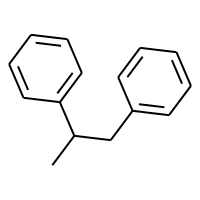
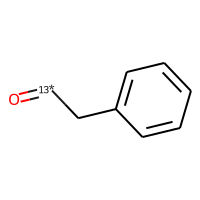
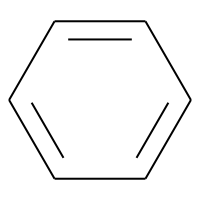
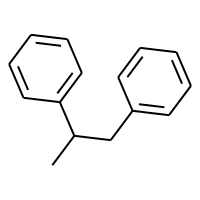
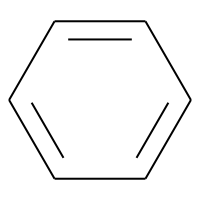
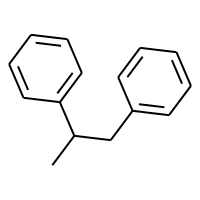
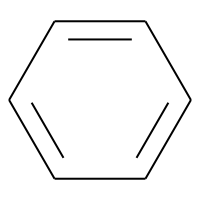
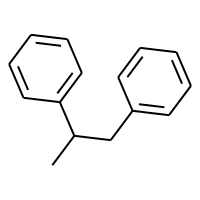
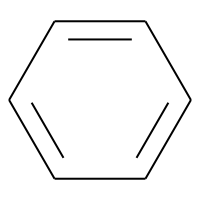
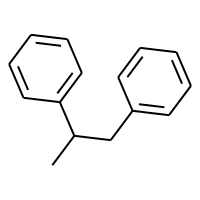
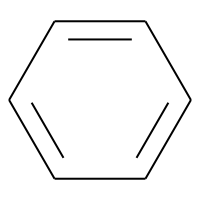
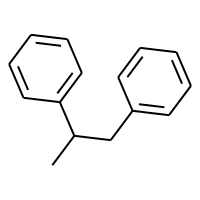
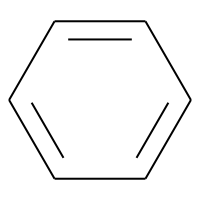
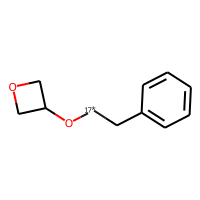
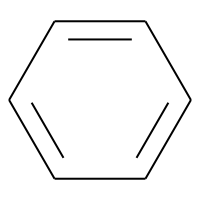
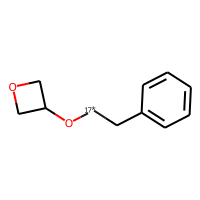
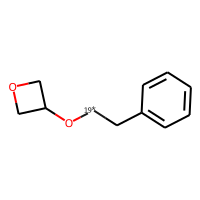
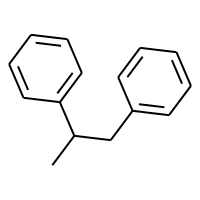
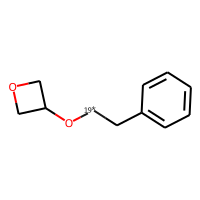
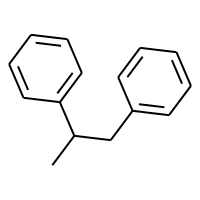
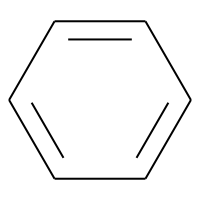
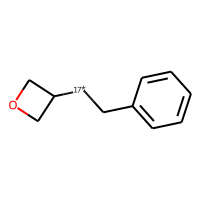
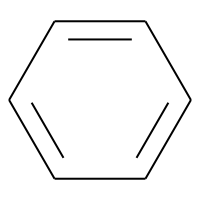
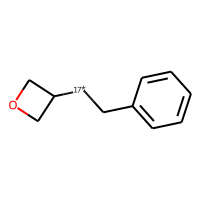
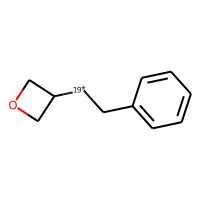
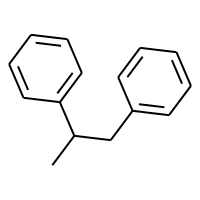
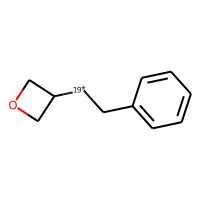
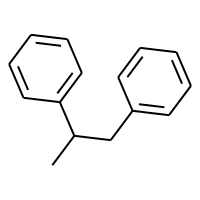
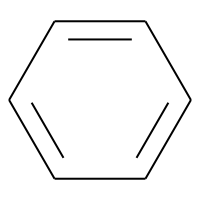
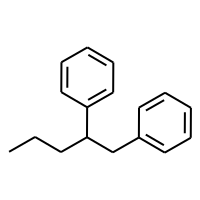
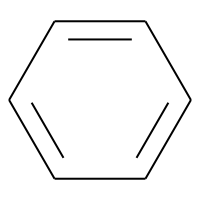
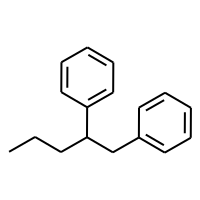
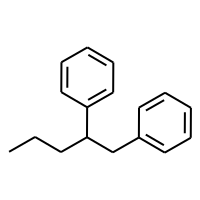
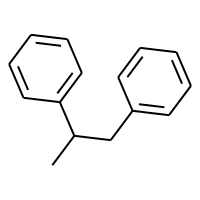
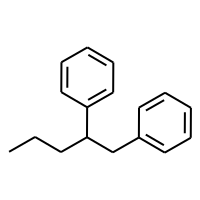
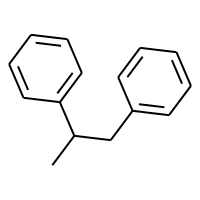
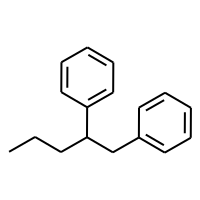
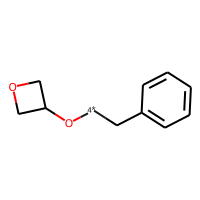
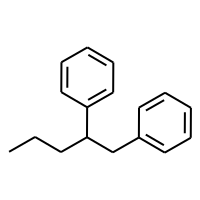
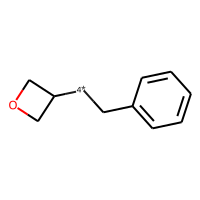

In [53]:
show_df(graft_pair_df.head(20))